# Setup

## Package Installation

In [ ]:
#%pip install torchvision
#!pip uninstall -y torch torchvision torchaudio
#%pip install torch==2.6.0+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [1]:
import os
import random
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR100
from torchvision.models import resnet50, resnet18
from PIL import Image
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import gc

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using the device {}.'.format(device))
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

2.6.0+cu124
We are using the device cuda.
Device count: 1
Device name: NVIDIA A100-SXM4-40GB


## Utils

In [2]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
clear_gpu_memory()

In [135]:
def display_gpu_memory():
    # Display total GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # Display currently allocated memory
    print(f"Currently allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

    # Display cached memory (reserved by PyTorch but not used)
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
display_gpu_memory()

Total GPU memory: 39.39 GB
Currently allocated: 1.36 GB
Cached: 3.15 GB


## Dataset

In [4]:
# Get Dataset
dataset = CIFAR100(root='./data', train=True, download=True)
print(dataset)

with open('data/cifar-100-python/meta', 'rb') as fo:
    metadata = pickle.load(fo, encoding='bytes')

classLabels = dict(list(enumerate(metadata[b'fine_label_names'])))
print(classLabels)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
{0: b'apple', 1: b'aquarium_fish', 2: b'baby', 3: b'bear', 4: b'beaver', 5: b'bed', 6: b'bee', 7: b'beetle', 8: b'bicycle', 9: b'bottle', 10: b'bowl', 11: b'boy', 12: b'bridge', 13: b'bus', 14: b'butterfly', 15: b'camel', 16: b'can', 17: b'castle', 18: b'caterpillar', 19: b'cattle', 20: b'chair', 21: b'chimpanzee', 22: b'clock', 23: b'cloud', 24: b'cockroach', 25: b'couch', 26: b'crab', 27: b'crocodile', 28: b'cup', 29: b'dinosaur', 30: b'dolphin', 31: b'elephant', 32: b'flatfish', 33: b'forest', 34: b'fox', 35: b'girl', 36: b'hamster', 37: b'house', 38: b'kangaroo', 39: b'keyboard', 40: b'lamp', 41: b'lawn_mower', 42: b'leopard', 43: b'lion', 44: b'lizard', 45: b'lobster', 46: b'man', 47: b'maple_tree', 48: b'motorcycle', 49: b'mountain', 50: b'mouse', 51: b'mushroom', 52: b'oak_tree', 53: b'orange', 54: b'orchid', 55: b'otter', 56: b'palm_tree', 57: b'pear', 58: b'pickup_truck', 59: b'pine_tre

In [5]:
with open('data/cifar-100-python/train', 'rb') as fo:
    trainMeta = pickle.load(fo, encoding='bytes')

with open('data/cifar-100-python/test', 'rb') as fo:
    testMeta = pickle.load(fo, encoding='bytes')


totalTest = len(testMeta[b'data'])
valNum = 4000

# Get training/testing data and labels
trainData = trainMeta[b'data']
trainData = trainData.reshape((len(trainData), 3, 32, 32))
trainLabel = np.array(trainMeta[b'fine_labels'])

mask = list(range(valNum))
valData = testMeta[b'data'][mask]
valData = valData.reshape((len(valData), 3, 32, 32))
valLabel = np.array(testMeta[b'fine_labels'])[mask]

mask = list(range(valNum, totalTest))
testData = testMeta[b'data'][mask]
testData = testData.reshape((len(testData), 3, 32, 32))
testLabel = np.array(testMeta[b'fine_labels'])[mask]

[500, 485, 470, 456, 442, 429, 416, 404, 392, 380, 369, 358, 347, 337, 327, 317, 308, 298, 290, 281, 272, 264, 256, 249, 241, 234, 227, 220, 214, 207, 201, 195, 189, 184, 178, 173, 168, 163, 158, 153, 149, 144, 140, 136, 132, 128, 124, 120, 116, 113, 110, 106, 103, 100, 97, 94, 91, 89, 86, 83, 81, 78, 76, 74, 72, 69, 67, 65, 63, 61, 60, 58, 56, 54, 53, 51, 50, 48, 47, 45, 44, 43, 41, 40, 39, 38, 37, 35, 34, 33, 32, 31, 30, 29, 29, 28, 27, 26, 25, 25]
15907


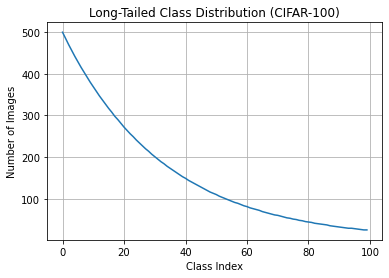

In [6]:
# Get the number of images per class
imgPerClass = []

for cls in range(100):
    num = 500 * (0.05 ** (cls / 99))
    imgPerClass.append(int(num))

print(imgPerClass)
print(np.sum(imgPerClass))
plt.plot(imgPerClass)
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Long-Tailed Class Distribution (CIFAR-100)")
plt.grid(True)
plt.show()

In [7]:
# Get LT training data
trainDataLT, trainLabelLT = [], []
clsList = list(range(100))
random.shuffle(clsList)

for cls, numImg in enumerate(imgPerClass):
    clsIndx = np.where(trainLabel == clsList[cls])[0]
    numSampledImages = np.random.choice(clsIndx, numImg, replace=False)

    trainDataLT.append(trainData[numSampledImages])
    trainLabelLT.append(trainLabel[numSampledImages])

trainDataLT, trainLabelLT = np.concatenate(trainDataLT), np.concatenate(trainLabelLT)

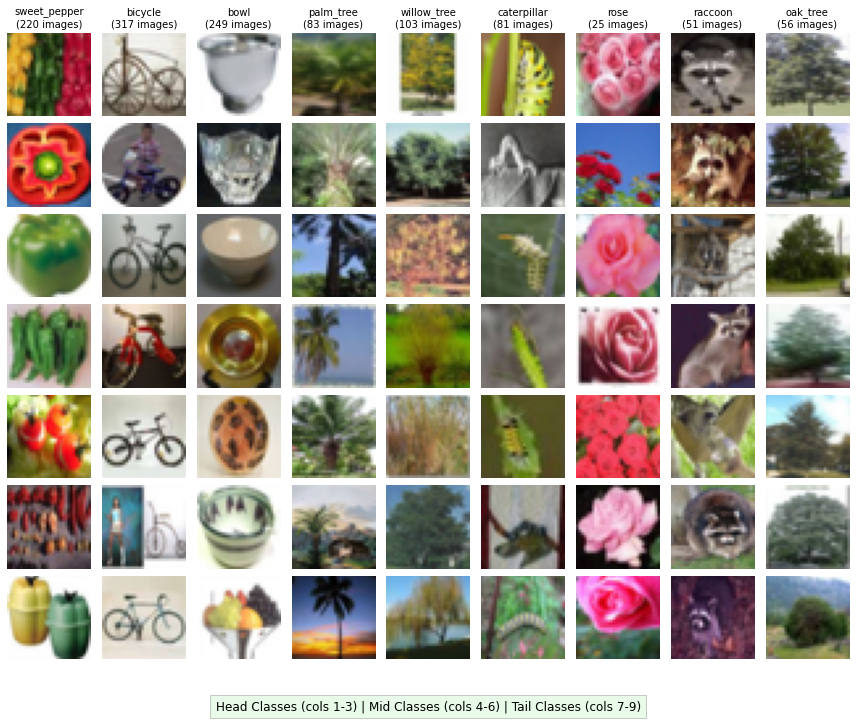

In [10]:
def visualize_long_tail_classes(train_data, train_labels, class_list, class_labels, samples_per_class=7):
    """
    Visualize samples from long-tailed dataset, showing head, mid, and tail classes.
    
    Args:
    - train_data: Training images array in format (N, C, H, W)
    - train_labels: Training labels array
    - class_list: List of class indices 
    - class_labels: Dictionary mapping class indices to class names
    - samples_per_class: Number of samples to show per class
    """
    head_classes = class_list[:30]
    mid_classes = class_list[30:70] 
    tail_classes = class_list[70:]
    
    np.random.seed(42)
    selected_head = np.random.choice(head_classes, 3, replace=False)
    selected_mid = np.random.choice(mid_classes, 3, replace=False)
    selected_tail = np.random.choice(tail_classes, 3, replace=False)
    selected_classes = np.concatenate([selected_head, selected_mid, selected_tail])
    
    plt.figure(figsize=(12, 10))
    for i, class_idx in enumerate(selected_classes):
        idxs = np.flatnonzero(train_labels == class_idx)
        num_found = len(idxs)
        
        if num_found > 0:
            samples_to_show = min(samples_per_class, num_found)
            idxs = np.random.choice(idxs, samples_to_show, replace=False)
            
            for j, idx in enumerate(idxs):
                plt_idx = j * len(selected_classes) + i + 1
                plt.subplot(samples_per_class, len(selected_classes), plt_idx)
                
                img = np.transpose(train_data[idx], (1, 2, 0)).astype('uint8')
                plt.imshow(img)
                plt.axis('off')
                
                if j == 0:
                    if isinstance(class_labels[class_idx], bytes):
                        class_name = class_labels[class_idx].decode('utf-8')
                    else:
                        class_name = class_labels[class_idx]
                    count = np.sum(train_labels == class_idx)
                    plt.title(f"{class_name}\n({count} images)", fontsize=10)
    
    plt.figtext(0.5, 0.01, "Head Classes (cols 1-3) | Mid Classes (cols 4-6) | Tail Classes (cols 7-9)", 
               ha="center", fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.show()

# Example usage:
# For original data:
visualize_long_tail_classes(trainDataLT, trainLabelLT, clsList, classLabels)
# 
# For augmented/generated data:
# visualize_long_tail_classes(augmentedLT, augmentedLabelsLT, clsList, classLabels)

# Training

In [30]:
def plot_training_results(trainLosses, trainAccs, valAccs, batchLosses, freq):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(trainLosses) + 1)
    ax1.plot(epochs, trainLosses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss per Epoch')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='lower left')
    
    batchX = np.arange(len(batchLosses)) * freq
    ax1_inset = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
    ax1_inset.plot(batchX, batchLosses, 'r-', alpha=0.7)
    ax1_inset.set_title('Batch Losses')

    ax2.plot(epochs, trainAccs, 'g-', label='Training Accuracy')
    ax2.plot(epochs, valAccs, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_results.png', dpi=300, bbox_inches='tight')

In [32]:
def train_model(trainData, valData, epochs: int, model=None, optimizer=None, scheduler=None, lossFunc=None, freq=200) -> None:
    trainLosses = []
    trainAccs = []
    valAccs = []
    batchLosses = []
    for epoch in range(epochs):
        model.train()
        avgLoss = 0
        batchCorrect = 0
        batchNum = 0
        totalCorrect = 0
        totalNum = 0
        
        epochLosses = []
        for i, batch in tqdm(enumerate(trainData)):
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = lossFunc(output, labels)
            loss.backward()
            optimizer.step()
            
            lossValue = loss.item()
            avgLoss += lossValue
            epochLosses.append(lossValue)
            
            pred = torch.argmax(output, 1)
            batchCorrect += (pred == labels).sum().item()
            totalCorrect += (pred == labels).sum().item()
            totalNum += labels.size(0)
            batchNum += labels.size(0)
            if i % freq == 0:
                avgLossBatch = avgLoss / freq if i > 0 else avgLoss
                accuracy = batchCorrect / batchNum if batchNum > 0 else 0
                batchLosses.append(avgLossBatch)
                avgLoss = 0.0
                batchCorrect = 0.0
                batchNum = 0.0
        
        scheduler.step()
        valAcc, *_ = test_model(model, valData, True)
        trainAcc = totalCorrect / totalNum
        
        meanEpochLoss = np.mean(epochLosses) if epochLosses else 0
        trainLosses.append(meanEpochLoss)
        trainAccs.append(trainAcc)
        valAccs.append(valAcc)
        
        print(f'Epoch {epoch + 1}/{epochs} completed: val acc={valAcc:.3f}, train acc={trainAcc:.3f}, epoch loss={meanEpochLoss:.3f}')
        
        totalCorrect = 0
        totalNum = 0
    
    plot_training_results(trainLosses, trainAccs, valAccs, batchLosses, freq)
    
    return trainLosses, trainAccs, valAccs

# Testing

In [28]:
def test_model(model, dataSet, classAcc=False):

    model.eval()
    correct = 0
    total = 0

    classCorrect = defaultdict(int)
    classTotal = defaultdict(int)

    with torch.no_grad():
        for batch_data in dataSet:
            images, labels = batch_data

            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            predicted = torch.argmax(output, 1)

            for label, pred in zip(labels, predicted):
                classTotal[label.item()] += 1
                if pred == label:
                    classCorrect[label.item()] += 1

                total += 1
                correct += (pred == label).item()

    acc = correct / total

    if classAcc:
        head = clsList[:30]
        mid = clsList[30:70]
        tail = clsList[70:]

        def groupAcc(group):
            return sum(classCorrect[c] for c in group) / sum(classTotal[c] for c in group)

        headAcc = groupAcc(head)
        midAcc = groupAcc(mid)
        tailAcc = groupAcc(tail)

        print(f"Test Accuracy - Overall: {100*acc:.2f}% | Head: {100*headAcc:.2f}% | Mid: {100*midAcc:.2f}% | Tail: {100*tailAcc:.2f}%")
        return acc, headAcc, midAcc, tailAcc

    return acc

# Base Model (ResNet-50)

498it [00:12, 41.20it/s]


Test Accuracy - Overall: 3.40% | Head: 10.12% | Mid: 0.81% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.034, train acc=0.057


498it [00:11, 42.95it/s]


Test Accuracy - Overall: 3.55% | Head: 10.94% | Mid: 0.56% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.035, train acc=0.088


498it [00:12, 40.73it/s]


Test Accuracy - Overall: 4.55% | Head: 12.42% | Mid: 1.62% | Tail: 0.42%
Epoch 3/20 completed: val acc=0.045, train acc=0.103


498it [00:11, 45.09it/s]


Test Accuracy - Overall: 7.58% | Head: 20.48% | Mid: 2.55% | Tail: 1.10%
Epoch 4/20 completed: val acc=0.076, train acc=0.132


498it [00:11, 45.19it/s]


Test Accuracy - Overall: 9.53% | Head: 19.49% | Mid: 7.23% | Tail: 2.37%
Epoch 5/20 completed: val acc=0.095, train acc=0.166


498it [00:11, 43.99it/s]


Test Accuracy - Overall: 10.93% | Head: 23.27% | Mid: 8.91% | Tail: 0.93%
Epoch 6/20 completed: val acc=0.109, train acc=0.194


498it [00:11, 41.64it/s]


Test Accuracy - Overall: 13.33% | Head: 25.74% | Mid: 12.90% | Tail: 1.10%
Epoch 7/20 completed: val acc=0.133, train acc=0.224


498it [00:12, 41.44it/s]


Test Accuracy - Overall: 14.55% | Head: 27.30% | Mid: 14.39% | Tail: 1.61%
Epoch 8/20 completed: val acc=0.145, train acc=0.252


498it [00:11, 43.08it/s]


Test Accuracy - Overall: 14.32% | Head: 25.00% | Mid: 14.58% | Tail: 2.97%
Epoch 9/20 completed: val acc=0.143, train acc=0.288


498it [00:11, 43.59it/s]


Test Accuracy - Overall: 14.12% | Head: 29.85% | Mid: 10.59% | Tail: 2.71%
Epoch 10/20 completed: val acc=0.141, train acc=0.319


498it [00:10, 45.82it/s]


Test Accuracy - Overall: 20.03% | Head: 36.43% | Mid: 20.25% | Tail: 2.80%
Epoch 11/20 completed: val acc=0.200, train acc=0.289


498it [00:11, 41.67it/s]


Test Accuracy - Overall: 22.90% | Head: 39.39% | Mid: 23.18% | Tail: 5.51%
Epoch 12/20 completed: val acc=0.229, train acc=0.368


498it [00:11, 43.87it/s]


Test Accuracy - Overall: 23.43% | Head: 41.12% | Mid: 22.99% | Tail: 5.77%
Epoch 13/20 completed: val acc=0.234, train acc=0.415


498it [00:11, 43.91it/s]


Test Accuracy - Overall: 25.82% | Head: 45.81% | Mid: 24.80% | Tail: 6.62%
Epoch 14/20 completed: val acc=0.258, train acc=0.461


498it [00:12, 40.42it/s]


Test Accuracy - Overall: 27.27% | Head: 44.16% | Mid: 27.98% | Tail: 8.91%
Epoch 15/20 completed: val acc=0.273, train acc=0.511


498it [00:11, 42.31it/s]


Test Accuracy - Overall: 28.43% | Head: 44.65% | Mid: 30.47% | Tail: 8.91%
Epoch 16/20 completed: val acc=0.284, train acc=0.574


498it [00:11, 42.07it/s]


Test Accuracy - Overall: 29.05% | Head: 45.39% | Mid: 31.09% | Tail: 9.41%
Epoch 17/20 completed: val acc=0.290, train acc=0.638


498it [00:11, 43.72it/s]


Test Accuracy - Overall: 29.78% | Head: 46.88% | Mid: 31.78% | Tail: 9.41%
Epoch 18/20 completed: val acc=0.298, train acc=0.703


498it [00:11, 43.10it/s]


Test Accuracy - Overall: 29.12% | Head: 46.46% | Mid: 31.28% | Tail: 8.31%
Epoch 19/20 completed: val acc=0.291, train acc=0.753


498it [00:11, 43.18it/s]


Test Accuracy - Overall: 29.50% | Head: 46.79% | Mid: 31.28% | Tail: 9.25%
Epoch 20/20 completed: val acc=0.295, train acc=0.777


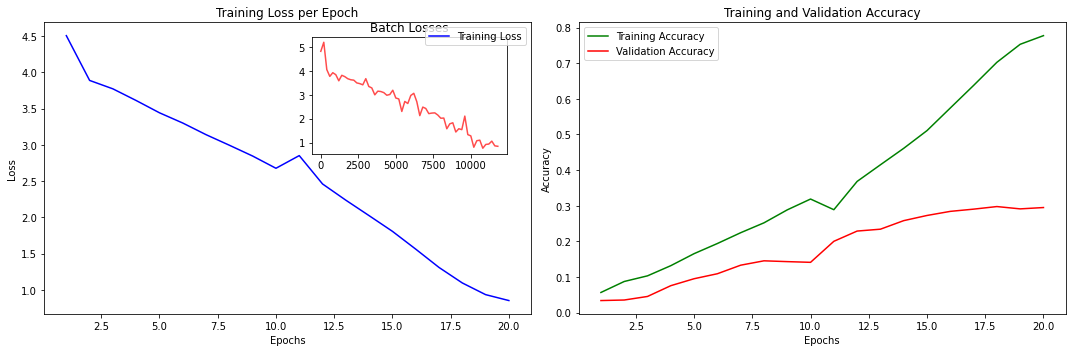

([4.5057691546329055,
  3.8883551244276116,
  3.7720960469609763,
  3.6109961228198317,
  3.4418367650135453,
  3.3006946456480217,
  3.1401539047559104,
  2.994697589472116,
  2.8455516909020973,
  2.6769664871644783,
  2.851717615941442,
  2.460801778548214,
  2.2370281748503564,
  2.023528995044739,
  1.8076889534073182,
  1.562229080372546,
  1.3096350373992,
  1.095872341629013,
  0.9347271195137836,
  0.8530059801526817],
 [0.056704595461117745,
  0.08750864399321054,
  0.10335072609542968,
  0.13189162004149116,
  0.16558747721129063,
  0.19406550575218456,
  0.22436663104293708,
  0.2520902747218206,
  0.2884893443138241,
  0.31885333500974417,
  0.28892940214999685,
  0.36832840887659524,
  0.4149745395109071,
  0.46118061230904633,
  0.5109071477965675,
  0.5743383416106117,
  0.6376438046143207,
  0.7025209027472182,
  0.7530646885019174,
  0.7773307348965864],
 [0.034,
  0.0355,
  0.0455,
  0.07575,
  0.09525,
  0.10925,
  0.13325,
  0.1455,
  0.14325,
  0.14125,
  0.20025,

In [29]:
# Cifar-100 LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesLT, trainAccLT, valAccLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

1563it [00:38, 40.93it/s]


Test Accuracy - Overall: 7.85% | Head: 6.91% | Mid: 10.16% | Tail: 5.68%
Epoch 1/20 completed: val acc=0.079, train acc=0.042


1563it [00:34, 45.25it/s]


Test Accuracy - Overall: 12.38% | Head: 10.86% | Mid: 12.96% | Tail: 13.15%
Epoch 2/20 completed: val acc=0.124, train acc=0.099


1563it [00:36, 42.73it/s]


Test Accuracy - Overall: 19.98% | Head: 15.46% | Mid: 23.18% | Tail: 20.27%
Epoch 3/20 completed: val acc=0.200, train acc=0.168


1563it [00:35, 43.50it/s]


Test Accuracy - Overall: 23.67% | Head: 17.60% | Mid: 31.59% | Tail: 19.17%
Epoch 4/20 completed: val acc=0.237, train acc=0.241


1563it [00:37, 42.15it/s]


Test Accuracy - Overall: 35.08% | Head: 29.44% | Mid: 39.75% | Tail: 34.52%
Epoch 5/20 completed: val acc=0.351, train acc=0.315


1563it [00:37, 42.10it/s]


Test Accuracy - Overall: 38.10% | Head: 33.06% | Mid: 41.68% | Tail: 38.42%
Epoch 6/20 completed: val acc=0.381, train acc=0.377


1563it [00:35, 44.26it/s]


Test Accuracy - Overall: 41.33% | Head: 35.77% | Mid: 46.36% | Tail: 40.20%
Epoch 7/20 completed: val acc=0.413, train acc=0.437


1563it [00:37, 42.13it/s]


Test Accuracy - Overall: 46.60% | Head: 43.83% | Mid: 48.60% | Tail: 46.73%
Epoch 8/20 completed: val acc=0.466, train acc=0.500


1563it [00:37, 41.45it/s]


Test Accuracy - Overall: 47.60% | Head: 41.45% | Mid: 52.02% | Tail: 47.92%
Epoch 9/20 completed: val acc=0.476, train acc=0.557


1563it [00:37, 41.90it/s]


Test Accuracy - Overall: 48.93% | Head: 44.41% | Mid: 51.15% | Tail: 50.55%
Epoch 10/20 completed: val acc=0.489, train acc=0.632


1563it [00:36, 42.69it/s]


Test Accuracy - Overall: 50.48% | Head: 45.81% | Mid: 53.02% | Tail: 51.82%
Epoch 11/20 completed: val acc=0.505, train acc=0.714


1563it [00:37, 42.04it/s]


Test Accuracy - Overall: 50.60% | Head: 48.60% | Mid: 51.71% | Tail: 51.15%
Epoch 12/20 completed: val acc=0.506, train acc=0.805


1563it [00:36, 42.82it/s]


Test Accuracy - Overall: 50.88% | Head: 44.90% | Mid: 54.02% | Tail: 52.76%
Epoch 13/20 completed: val acc=0.509, train acc=0.886


1563it [00:35, 43.68it/s]


Test Accuracy - Overall: 51.80% | Head: 47.12% | Mid: 55.33% | Tail: 51.82%
Epoch 14/20 completed: val acc=0.518, train acc=0.940


1563it [00:37, 41.86it/s]


Test Accuracy - Overall: 51.20% | Head: 45.97% | Mid: 53.83% | Tail: 53.01%
Epoch 15/20 completed: val acc=0.512, train acc=0.973


1563it [00:36, 42.57it/s]


Test Accuracy - Overall: 52.65% | Head: 49.10% | Mid: 54.52% | Tail: 53.77%
Epoch 16/20 completed: val acc=0.526, train acc=0.987


1563it [00:35, 43.87it/s]


Test Accuracy - Overall: 52.15% | Head: 48.19% | Mid: 54.70% | Tail: 52.76%
Epoch 17/20 completed: val acc=0.521, train acc=0.994


1563it [00:37, 41.79it/s]


Test Accuracy - Overall: 52.52% | Head: 48.27% | Mid: 55.89% | Tail: 52.33%
Epoch 18/20 completed: val acc=0.525, train acc=0.997


1563it [00:35, 43.93it/s]


Test Accuracy - Overall: 52.88% | Head: 47.94% | Mid: 55.95% | Tail: 53.77%
Epoch 19/20 completed: val acc=0.529, train acc=0.998


1563it [00:36, 43.18it/s]


Test Accuracy - Overall: 53.10% | Head: 48.77% | Mid: 55.89% | Tail: 53.77%
Epoch 20/20 completed: val acc=0.531, train acc=0.999


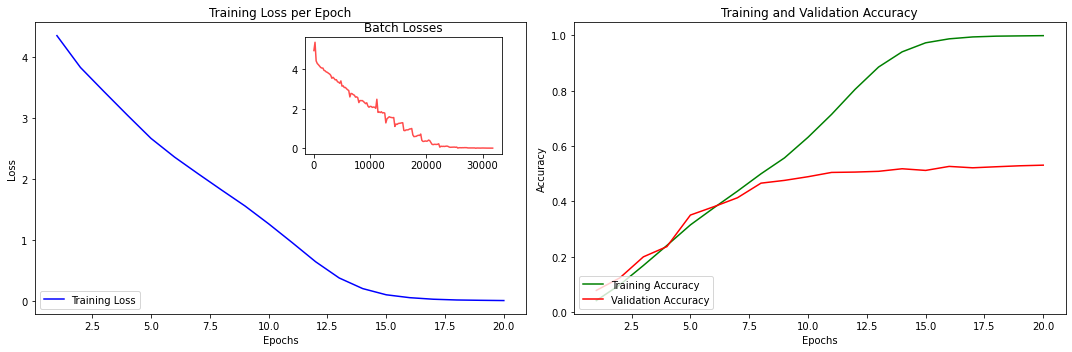

In [31]:
# Cifar-100 Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainData), torch.Tensor(trainLabel).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
losses, trainAcc, valAcc = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# Data Augmentation

In [64]:
transformVis = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transformTrain = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

def augment_image(baseImg, forTraining=True):
    imgArray = np.transpose(baseImg, (1, 2, 0))
    img = Image.fromarray(imgArray.astype(np.uint8))
    
    if forTraining:
        return transformTrain(img)
    else:
        return transformVis(img)

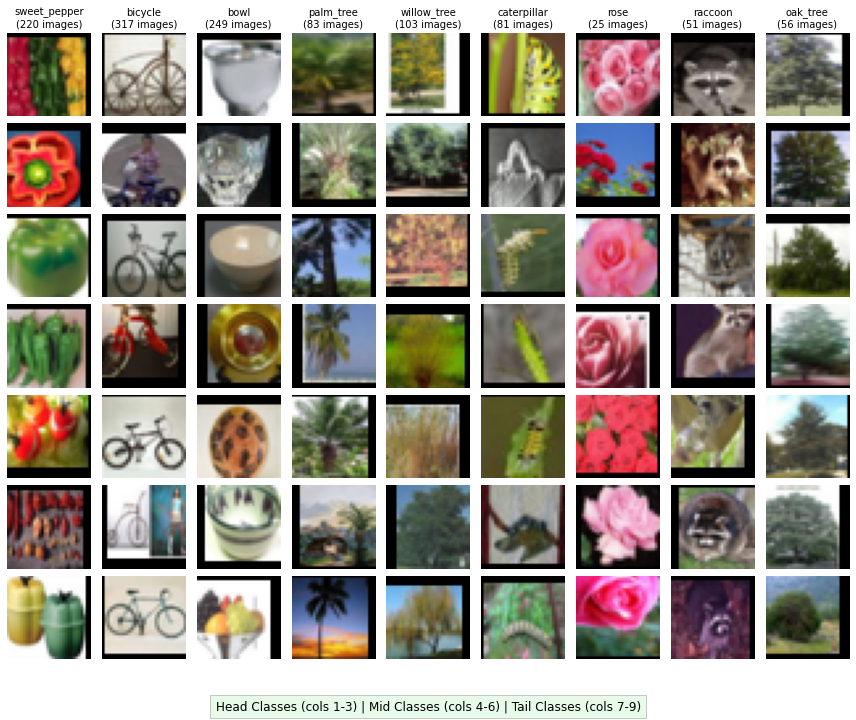

In [66]:
augmentedVis = [augment_image(img, forTraining=False) for img in trainDataLT]
augmentedVis = torch.stack(augmentedVis)

augmentedTrain = [augment_image(img) for img in trainDataLT]
augmentedTrain = torch.stack(augmentedTrain)

augmentedVisImages = augmentedVis.numpy() * 255 # ToTensor normalizes between 0-1, so need to multiply by 255
augmentedTrainImages = augmentedTrain.numpy()
augmentedLabels = np.array(trainLabelLT)

visualize_long_tail_classes(augmentedVisImages, augmentedLabels, clsList, classLabels)

In [67]:
augmentedLT = np.concatenate([trainDataLT, augmentedTrainImages], axis=0)
augmentedLabelsLT = np.concatenate([trainLabelLT, augmentedLabels], axis=0)
print(augmentedLT.shape, augmentedLabelsLT.shape)

(31814, 3, 32, 32) (31814,)


995it [00:21, 45.99it/s]


Test Accuracy - Overall: 3.57% | Head: 11.68% | Mid: 0.06% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.036, train acc=0.055, epoch loss=4.411


995it [00:21, 46.35it/s]


Test Accuracy - Overall: 4.50% | Head: 14.72% | Mid: 0.06% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.045, train acc=0.085, epoch loss=3.928


995it [00:21, 46.53it/s]


Test Accuracy - Overall: 5.88% | Head: 13.82% | Mid: 4.11% | Tail: 0.08%
Epoch 3/20 completed: val acc=0.059, train acc=0.099, epoch loss=3.802


995it [00:21, 45.58it/s]


Test Accuracy - Overall: 8.80% | Head: 17.27% | Mid: 7.85% | Tail: 1.36%
Epoch 4/20 completed: val acc=0.088, train acc=0.120, epoch loss=3.687


995it [00:21, 45.24it/s]


Test Accuracy - Overall: 9.57% | Head: 20.72% | Mid: 6.60% | Tail: 2.12%
Epoch 5/20 completed: val acc=0.096, train acc=0.142, epoch loss=3.567


995it [00:24, 40.99it/s]


Test Accuracy - Overall: 11.50% | Head: 24.42% | Mid: 9.03% | Tail: 1.53%
Epoch 6/20 completed: val acc=0.115, train acc=0.166, epoch loss=3.455


995it [00:23, 43.11it/s]


Test Accuracy - Overall: 13.75% | Head: 29.28% | Mid: 10.28% | Tail: 2.46%
Epoch 7/20 completed: val acc=0.138, train acc=0.191, epoch loss=3.310


995it [00:22, 43.48it/s]


Test Accuracy - Overall: 15.32% | Head: 27.96% | Mid: 15.02% | Tail: 2.71%
Epoch 8/20 completed: val acc=0.153, train acc=0.224, epoch loss=3.167


995it [00:22, 44.91it/s]


Test Accuracy - Overall: 17.38% | Head: 33.39% | Mid: 15.45% | Tail: 3.48%
Epoch 9/20 completed: val acc=0.174, train acc=0.258, epoch loss=3.002


995it [00:22, 43.57it/s]


Test Accuracy - Overall: 21.43% | Head: 35.94% | Mid: 23.43% | Tail: 3.73%
Epoch 10/20 completed: val acc=0.214, train acc=0.295, epoch loss=2.820


995it [00:21, 45.62it/s]


Test Accuracy - Overall: 21.90% | Head: 38.57% | Mid: 21.06% | Tail: 5.85%
Epoch 11/20 completed: val acc=0.219, train acc=0.337, epoch loss=2.621


995it [00:21, 45.63it/s]


Test Accuracy - Overall: 24.77% | Head: 41.37% | Mid: 24.92% | Tail: 7.46%
Epoch 12/20 completed: val acc=0.248, train acc=0.382, epoch loss=2.397


995it [00:23, 42.90it/s]


Test Accuracy - Overall: 24.93% | Head: 42.02% | Mid: 25.61% | Tail: 6.36%
Epoch 13/20 completed: val acc=0.249, train acc=0.435, epoch loss=2.139


995it [00:21, 46.31it/s]


Test Accuracy - Overall: 26.47% | Head: 42.68% | Mid: 27.41% | Tail: 8.48%
Epoch 14/20 completed: val acc=0.265, train acc=0.500, epoch loss=1.860


995it [00:21, 45.68it/s]


Test Accuracy - Overall: 27.93% | Head: 44.98% | Mid: 28.22% | Tail: 9.92%
Epoch 15/20 completed: val acc=0.279, train acc=0.570, epoch loss=1.560


995it [00:22, 43.99it/s]


Test Accuracy - Overall: 27.65% | Head: 44.41% | Mid: 28.47% | Tail: 9.25%
Epoch 16/20 completed: val acc=0.277, train acc=0.648, epoch loss=1.262


995it [00:21, 45.83it/s]


Test Accuracy - Overall: 28.23% | Head: 44.74% | Mid: 28.91% | Tail: 10.26%
Epoch 17/20 completed: val acc=0.282, train acc=0.727, epoch loss=0.995


995it [00:22, 44.66it/s]


Test Accuracy - Overall: 28.88% | Head: 45.56% | Mid: 29.41% | Tail: 10.94%
Epoch 18/20 completed: val acc=0.289, train acc=0.787, epoch loss=0.795


995it [00:23, 41.48it/s]


Test Accuracy - Overall: 28.30% | Head: 45.31% | Mid: 29.16% | Tail: 9.58%
Epoch 19/20 completed: val acc=0.283, train acc=0.826, epoch loss=0.672


995it [00:25, 39.68it/s]


Test Accuracy - Overall: 28.05% | Head: 45.39% | Mid: 28.54% | Tail: 9.50%
Epoch 20/20 completed: val acc=0.281, train acc=0.845, epoch loss=0.611


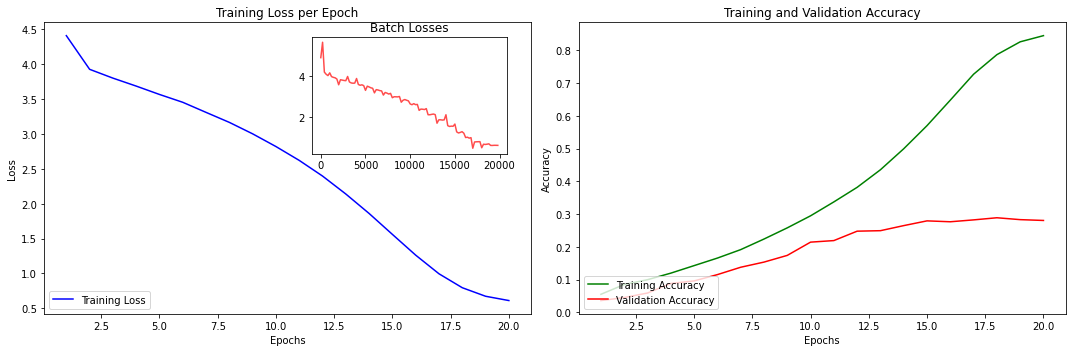

([4.411179073851312,
  3.9282033843610753,
  3.8018018260074022,
  3.6874666918462244,
  3.5674132629854594,
  3.4548943792755282,
  3.310111910613937,
  3.1666703075619798,
  3.0022870179995818,
  2.8201439114671256,
  2.6212291904430294,
  2.3967347661454474,
  2.1390268977562985,
  1.8599039246688536,
  1.5596191645866662,
  1.2618045495982146,
  0.994521730299571,
  0.7947257213856108,
  0.672279991935845,
  0.6106071280624399],
 [0.05488149871125919,
  0.08474256616583895,
  0.09945307097504244,
  0.11950713522348652,
  0.14248444081222103,
  0.1655246118061231,
  0.1913622933299805,
  0.22370654428867795,
  0.25787389199723393,
  0.2946815867228264,
  0.33717860061608096,
  0.38171874017728047,
  0.43540579619035646,
  0.49959137486641103,
  0.570220657572138,
  0.648173759979883,
  0.727352737788395,
  0.787137738102722,
  0.8263657509272647,
  0.8452253724775256],
 [0.03575,
  0.045,
  0.05875,
  0.088,
  0.09575,
  0.115,
  0.1375,
  0.15325,
  0.17375,
  0.21425,
  0.219,
  0

In [68]:
# Cifar-100 Augmented LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesAugLT, trainAccAugLT, valAccAugLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# Image Generation

## U-Net Blocks

In [106]:
# U-Net blocks using Group Normalization
class ResidualBlock(nn.Module):
    '''
    A residual block has two convolutional layers with group normalization.
    '''
    def __init__(self, in_channels, out_channels, time_channels=None, num_groups=8):
        '''
        args:
        - in_channels: the number of input channels
        - out_channels: the number of output channels
        - time_channels: the number channels in the time step ($t$) embeddings
        - num_groups: is the number of groups for group normalization
        '''
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        # skip connection
        self.skip_connection = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        # time embedding
        self.time_mlp = None
        if time_channels is not None:
            self.time_mlp = nn.Sequential(
                nn.Linear(time_channels, out_channels),
                nn.SiLU()
            )

    def forward(self, x, time_emb=None):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        if self.time_mlp is not None and time_emb is not None:
            time_condition = self.time_mlp(time_emb)
            h = h + time_condition.view(-1, time_condition.shape[1], 1, 1)
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.skip_connection(x)

In [107]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)

    def forward(self, x):
        x = self.norm(x)
        x = F.silu(x)
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, x):
        x = self.norm(x)
        x = F.silu(x)
        return self.conv(x)

In [108]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

## Lightweight U-Net

In [109]:
class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, time_embedding_dim=128, model_channels=64, num_groups=8):
        super().__init__()
        
        # time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.SiLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        
        # initial convolution
        self.input_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)
        
        # encoder
        self.enc1 = ResidualBlock(model_channels, model_channels, time_embedding_dim, num_groups)
        self.down1 = DownSample(model_channels, model_channels*2, num_groups)
        self.enc2 = ResidualBlock(model_channels*2, model_channels*2, time_embedding_dim, num_groups)
        self.down2 = DownSample(model_channels*2, model_channels*4, num_groups)
        self.enc3 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        
        # middle block (latent space)
        self.middle_block1 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        self.middle_block2 = ResidualBlock(model_channels*4, model_channels*4, time_embedding_dim, num_groups)
        
        # decoder
        self.up1 = UpSample(model_channels*4, model_channels*2, num_groups)
        self.dec1 = ResidualBlock(model_channels*4, model_channels*2, time_embedding_dim, num_groups)
        self.up2 = UpSample(model_channels*2, model_channels, num_groups)
        self.dec2 = ResidualBlock(model_channels*2, model_channels, time_embedding_dim, num_groups)
        self.dec3 = ResidualBlock(model_channels, model_channels, time_embedding_dim, num_groups)
        
        # final layer
        self.final_norm = nn.GroupNorm(num_groups, model_channels)
        self.final_conv = nn.Conv2d(model_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x, time):
        # time embedding
        t = self.time_embedding(time)
        
        # initial convolution
        x = self.input_conv(x)
        
        # encoder
        e1 = self.enc1(x, t)
        x = self.down1(e1)
        e2 = self.enc2(x, t)
        x = self.down2(e2)
        e3 = self.enc3(x, t)
        
        # middle block
        x = self.middle_block1(e3, t)
        x = self.middle_block2(x, t)
        
        # decoder
        x = self.up1(x)
        x = torch.cat([x, e2], dim=1) # skip connection
        x = self.dec1(x, t)
        x = self.up2(x)
        x = torch.cat([x, e1], dim=1) # skip connection
        x = self.dec2(x, t)
        x = self.dec3(x, t)
        
        # final layers
        x = self.final_norm(x)
        x = F.silu(x)
        x = self.final_conv(x)
        return x

## Diffusion Process

In [110]:
class DiffusionModel:
    def __init__(self, model, device, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the diffusion model.

        Args:
        - model: U-Net model for denoising
        - device: Device to run the model on
        - timesteps: Number of diffusion steps
        - beta_start: Starting value of noise schedule
        - beta_end: Ending value of noise schedule
        """
        self.model = model
        self.device = device
        self.timesteps = timesteps
        
        # noise schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        """
        Forward diffusion process: Add noise to the image

        Args:
        - x_start: Initial clean image (x_0)
        - t: Timestep
        - noise: Optional pre-generated noise

        Returns:
        - Noisy image at timestep t
        """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        # apply forward process: q(x_t | x_0) = sqrt(α_cumprod) * x_0 + sqrt(1 - α_cumprod) * ε
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, x, t, t_index):
        """
        Sample from the model at timestep t

        Args:
        - x: Current noisy image x_t
        - t: Current timestep
        - t_index: Index of the timestep

        Returns:
        - Predicted x_{t-1}
        """
        betas_t = self.betas[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].reshape(-1, 1, 1, 1)
        predicted_noise = self.model(x, t)

        # compute the mean for q(x_{t-1} | x_t, x_0)
        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index > 0:
            noise = torch.randn_like(x)
            variance = torch.sqrt(self.posterior_variance[t].reshape(-1, 1, 1, 1))
            return mean + variance * noise
        else:
            return mean

    def p_sample_loop(self, shape):
        """
        Generate samples by running the reverse diffusion process

        Args:
        - shape: Shape of the image to generate

        Returns:
        - Generated image
        """
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(shape).to(self.device)

            # iteratively denoise
            for t_index in reversed(range(self.timesteps)):
                t = torch.full((shape[0],), t_index, device=self.device, dtype=torch.long)
                x = self.p_sample(x, t, t_index)

            x = (x.clamp(-1, 1) + 1) / 2
        return x

    def train_step(self, x_0, optimizer):
        """
        One step of training the diffusion model

        Args:
        - x_0: Clean image
        - optimizer: Optimizer

        Returns:
        - Loss value
        """
        self.model.train()
        optimizer.zero_grad()

        batch_size = x_0.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device).long()

        noise = torch.randn_like(x_0)
        x_t = self.q_sample(x_0, t, noise)

        predicted_noise = self.model(x_t, t)

        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()

        optimizer.step()
        return loss.item()

## Diffusion Image Generator Class

In [111]:
class DiffusionGenerator:
    def __init__(self, device, timesteps=500, image_size=32, batch_size=5):
        self.device = device
        self.timesteps = timesteps
        self.image_size = image_size
        self.batch_size = batch_size

        self.model = SmallUNet(
            in_channels=3,
            time_embedding_dim=128,
            model_channels=64,
            num_groups=8
        ).to(device)
        self.diffusion = DiffusionModel(self.model, device, timesteps)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scale to [-1, 1]
        ])
        self.inverse_transform = transforms.Compose([
            transforms.Normalize((-1, -1, -1), (2, 2, 2)),  # Scale from [-1, 1] to [0, 1]
            transforms.ToPILImage()
        ])
        
        self.train_losses = []
    
    def train(self, class_images, epochs=100, lr=2e-4, verbose=1):
        """
        Train the diffusion model on images from a specific class

        Args:
        - class_images: Array of class images (N, 3, 32, 32)
        - epochs: Number of training epochs
        - lr: Learning rate
        - verbose: whether or not to use print statements
        """
        if not isinstance(class_images, torch.Tensor):
            images = []
            for img in class_images:
                if isinstance(img, np.ndarray):
                    img_tensor = torch.from_numpy(img).float() / 127.5 - 1
                    images.append(img_tensor)
                else:
                    img_tensor = self.transform(img)
                    images.append(img_tensor)
            x_train = torch.stack(images).to(self.device)
        else:
            # if already a tensor, just normalize
            x_train = class_images.to(self.device)
            if x_train.max() > 1.0:
                x_train = x_train / 127.5 - 1

        if len(x_train) < self.batch_size:
            # duplicate data to ensure at least one full batch
            repeat_factor = (self.batch_size // len(x_train)) + 1
            x_train = x_train.repeat(repeat_factor, 1, 1, 1)
            if verbose > 0:
                print(f"Small dataset: {len(class_images)} images. Duplicated to {len(x_train)}.")

        dataset = torch.utils.data.TensorDataset(x_train)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=min(self.batch_size, len(x_train)), shuffle=True
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.5)

        epoch_losses = []
        if verbose > 0:
            print(f"Training for {epochs} epochs on {len(x_train)} images...")
            
        for epoch in range(epochs):
            total_loss = 0
            num_batches = 0

            for batch in dataloader:
                x = batch[0]
                loss = self.diffusion.train_step(x, optimizer)
                total_loss += loss
                num_batches += 1

            avg_loss = total_loss / num_batches
            epoch_losses.append(avg_loss)
            scheduler.step()

            if verbose > 0 and (epoch % 30 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
                
        self.train_losses.extend(epoch_losses)
        return epoch_losses

    def generate_images(self, num_images=100, class_idx=None, seed=None):
        """
        Generate new images using the trained diffusion model

        Args:
        - num_images: Number of images to generate
        - class_idx: Class index (for saving purposes)
        - seed: Random seed for reproducibility

        Returns:
        - Array of generated images (num_images, 3, 32, 32) in [0, 1] range
        """
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        all_images = []
        remaining = num_images

        while remaining > 0:
            batch_size = min(self.batch_size, remaining)
            shape = (batch_size, 3, self.image_size, self.image_size)
            batch_images = self.diffusion.p_sample_loop(shape)
            all_images.append(batch_images.cpu())
            remaining -= batch_size

        all_images = torch.cat(all_images, dim=0)
        return all_images.numpy()

    def save_model(self, path):
        """Save model to disk"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'timesteps': self.timesteps,
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """Load model from disk"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if 'timesteps' in checkpoint:
            self.timesteps = checkpoint['timesteps']
            self.diffusion = DiffusionModel(self.model, self.device, self.timesteps)
        print(f"Model loaded from {path}")
    
    def plot_training_loss(self):
        """Plot the training loss"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses)
        plt.title('Diffusion Model Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()
        
    def visualize_samples(self, num_samples=10, title=None):
        """Visualize generated images"""
        samples = self.generate_images(num_samples)
        samples = samples.transpose(0, 2, 3, 1)
        
        plt.figure(figsize=(15, 5))
        for i in range(min(num_samples, 10)):
            plt.subplot(1, 10, i+1)
            plt.imshow(samples[i])
            plt.axis('off')
        
        if title:
            plt.suptitle(title)
        plt.tight_layout()
        plt.show()

## Image Generation for CIFAR-100 Long-Tail Classes

Identified 46 long-tail classes with fewer than 100 samples:
[ 0  1  2  5  6  9 11 12 14 16 18 19 21 23 27 28 32 33 34 35 36 39 43 45
 47 48 52 54 55 56 57 59 61 63 66 70 76 80 81 85 86 87 89 90 92 93]

Processing class 0...
Found 65 real examples
Training for 87 epochs on 65 images...
Epoch 1/87, Loss: 0.9470
Epoch 31/87, Loss: 0.1246
Epoch 61/87, Loss: 0.1039
Epoch 87/87, Loss: 0.2201
Generating 435 new images for class 0


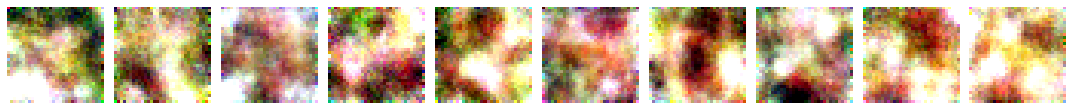


Processing class 1...
Found 76 real examples
Training for 84 epochs on 76 images...
Epoch 1/84, Loss: 0.1163
Epoch 31/84, Loss: 0.0885
Epoch 61/84, Loss: 0.0969
Epoch 84/84, Loss: 0.0822
Generating 424 new images for class 1


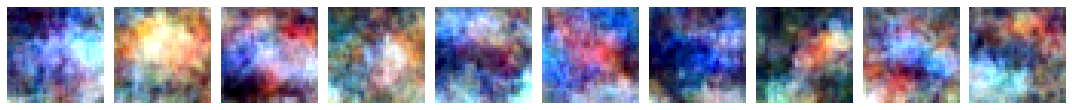


Processing class 2...
Found 53 real examples
Training for 89 epochs on 53 images...
Epoch 1/89, Loss: 0.0842
Epoch 31/89, Loss: 0.1182
Epoch 61/89, Loss: 0.0723
Epoch 89/89, Loss: 0.0842
Generating 447 new images for class 2


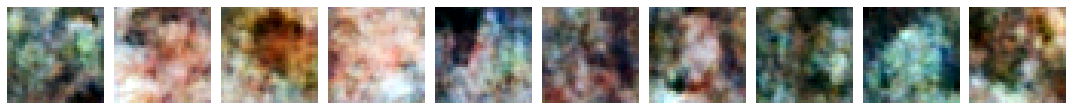


Processing class 5...
Found 40 real examples
Training for 92 epochs on 40 images...
Epoch 1/92, Loss: 0.0717
Epoch 31/92, Loss: 0.0737
Epoch 61/92, Loss: 0.1024
Epoch 91/92, Loss: 0.1044
Epoch 92/92, Loss: 0.0600
Generating 460 new images for class 5


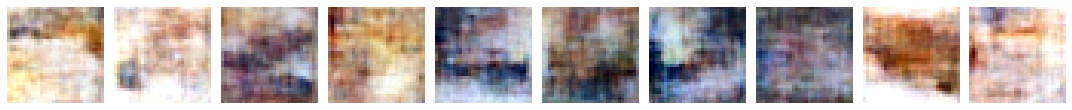


Processing class 6...
Found 86 real examples
Training for 82 epochs on 86 images...
Epoch 1/82, Loss: 0.0881
Epoch 31/82, Loss: 0.0706
Epoch 61/82, Loss: 0.0615
Epoch 82/82, Loss: 0.0886
Generating 414 new images for class 6


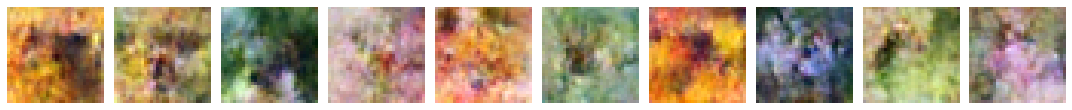


Processing class 9...
Found 63 real examples
Training for 87 epochs on 63 images...
Epoch 1/87, Loss: 0.0535
Epoch 31/87, Loss: 0.0515
Epoch 61/87, Loss: 0.0369
Epoch 87/87, Loss: 0.0376
Generating 437 new images for class 9


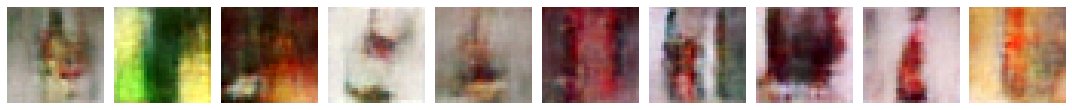


Processing class 11...
Found 34 real examples
Training for 93 epochs on 34 images...
Epoch 1/93, Loss: 0.0666
Epoch 31/93, Loss: 0.1359
Epoch 61/93, Loss: 0.0589
Epoch 91/93, Loss: 0.1337
Epoch 93/93, Loss: 0.0565
Generating 466 new images for class 11


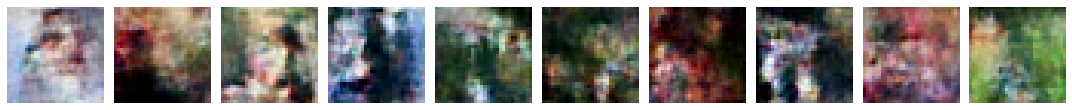


Processing class 12...
Found 78 real examples
Training for 84 epochs on 78 images...
Epoch 1/84, Loss: 0.0716
Epoch 31/84, Loss: 0.0500
Epoch 61/84, Loss: 0.0578
Epoch 84/84, Loss: 0.0387
Generating 422 new images for class 12


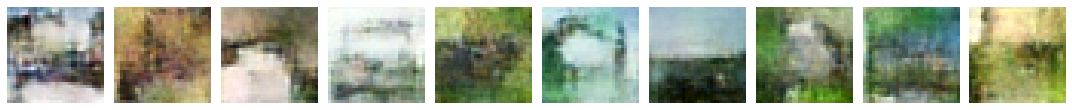


Processing class 14...
Found 25 real examples
Training for 95 epochs on 25 images...
Epoch 1/95, Loss: 0.0684
Epoch 31/95, Loss: 0.1355
Epoch 61/95, Loss: 0.0583
Epoch 91/95, Loss: 0.0892
Epoch 95/95, Loss: 0.0727
Generating 475 new images for class 14


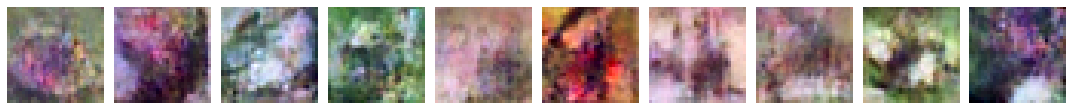


Processing class 16...
Found 69 real examples
Training for 86 epochs on 69 images...
Epoch 1/86, Loss: 0.0658
Epoch 31/86, Loss: 0.0810
Epoch 61/86, Loss: 0.0480
Epoch 86/86, Loss: 0.0525
Generating 431 new images for class 16


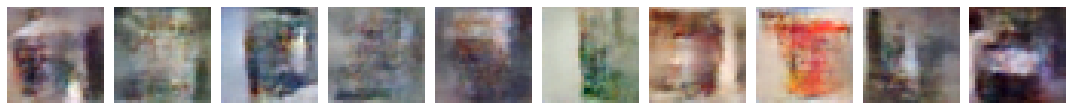


Processing class 18...
Found 81 real examples
Training for 83 epochs on 81 images...
Epoch 1/83, Loss: 0.0593
Epoch 31/83, Loss: 0.0434
Epoch 61/83, Loss: 0.0639
Epoch 83/83, Loss: 0.1247
Generating 419 new images for class 18


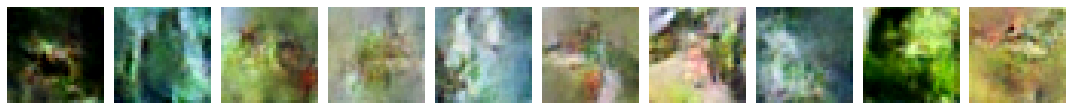


Processing class 19...
Found 45 real examples
Training for 91 epochs on 45 images...
Epoch 1/91, Loss: 0.0616
Epoch 31/91, Loss: 0.0526
Epoch 61/91, Loss: 0.0420
Epoch 91/91, Loss: 0.0545
Generating 455 new images for class 19


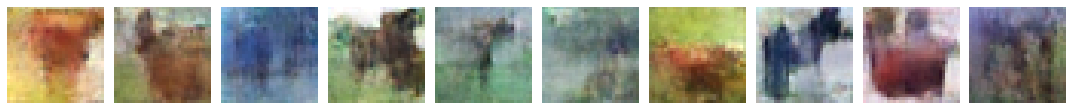


Processing class 21...
Found 48 real examples
Training for 90 epochs on 48 images...
Epoch 1/90, Loss: 0.0849
Epoch 31/90, Loss: 0.0444
Epoch 61/90, Loss: 0.0543
Epoch 90/90, Loss: 0.0490
Generating 452 new images for class 21


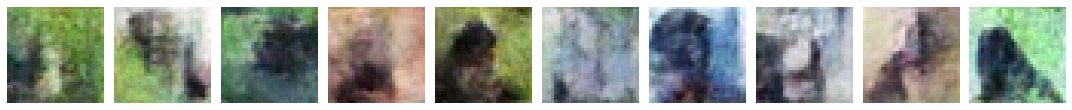


Processing class 23...
Found 58 real examples
Training for 88 epochs on 58 images...
Epoch 1/88, Loss: 0.0528
Epoch 31/88, Loss: 0.0315
Epoch 61/88, Loss: 0.0433
Epoch 88/88, Loss: 0.0306
Generating 442 new images for class 23


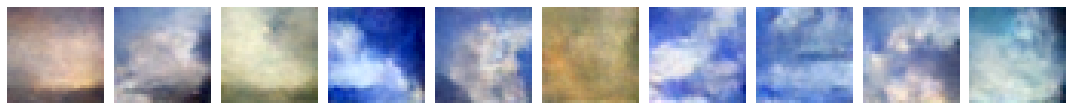


Processing class 27...
Found 94 real examples
Training for 81 epochs on 94 images...
Epoch 1/81, Loss: 0.0636
Epoch 31/81, Loss: 0.0450
Epoch 61/81, Loss: 0.0470
Epoch 81/81, Loss: 0.0464
Generating 406 new images for class 27


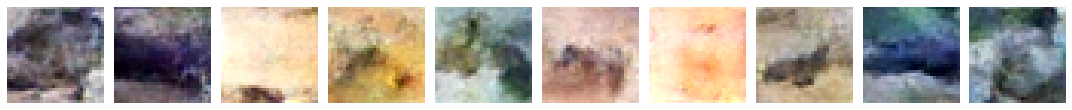


Processing class 28...
Found 44 real examples
Training for 91 epochs on 44 images...
Epoch 1/91, Loss: 0.0697
Epoch 31/91, Loss: 0.0221
Epoch 61/91, Loss: 0.0395
Epoch 91/91, Loss: 0.0212
Generating 456 new images for class 28


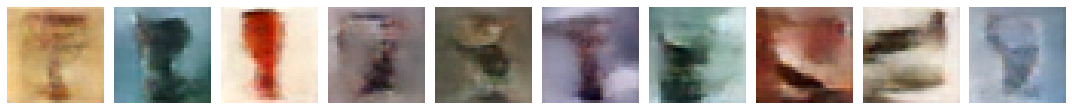


Processing class 32...
Found 35 real examples
Training for 93 epochs on 35 images...
Epoch 1/93, Loss: 0.1007
Epoch 31/93, Loss: 0.0466
Epoch 61/93, Loss: 0.0371
Epoch 91/93, Loss: 0.0405
Epoch 93/93, Loss: 0.0270
Generating 465 new images for class 32


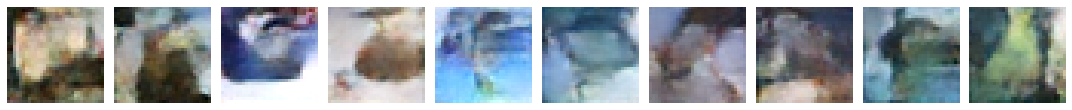


Processing class 33...
Found 33 real examples
Training for 93 epochs on 33 images...
Epoch 1/93, Loss: 0.0841
Epoch 31/93, Loss: 0.0379
Epoch 61/93, Loss: 0.0346
Epoch 91/93, Loss: 0.0366
Epoch 93/93, Loss: 0.0442
Generating 467 new images for class 33


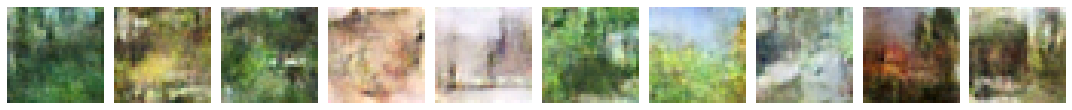


Processing class 34...
Found 60 real examples
Training for 88 epochs on 60 images...
Epoch 1/88, Loss: 0.0584
Epoch 31/88, Loss: 0.0400
Epoch 61/88, Loss: 0.0480
Epoch 88/88, Loss: 0.0486
Generating 440 new images for class 34


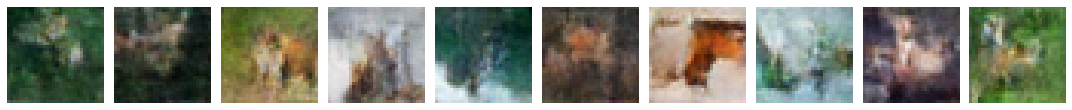


Processing class 35...
Found 32 real examples
Training for 93 epochs on 32 images...
Epoch 1/93, Loss: 0.0925
Epoch 31/93, Loss: 0.0413
Epoch 61/93, Loss: 0.0472
Epoch 91/93, Loss: 0.0568
Epoch 93/93, Loss: 0.0538
Generating 468 new images for class 35


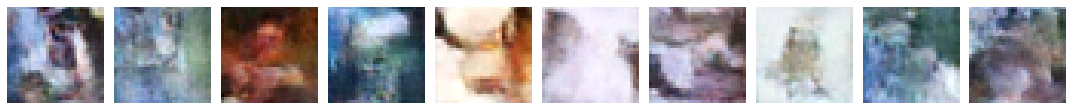


Processing class 36...
Found 47 real examples
Training for 90 epochs on 47 images...
Epoch 1/90, Loss: 0.0798
Epoch 31/90, Loss: 0.0361
Epoch 61/90, Loss: 0.0556
Epoch 90/90, Loss: 0.0292
Generating 453 new images for class 36


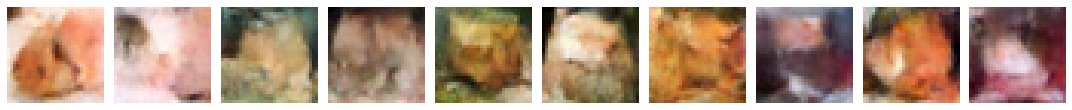


Processing class 39...
Found 97 real examples
Training for 80 epochs on 97 images...
Epoch 1/80, Loss: 0.0790
Epoch 31/80, Loss: 0.0958
Epoch 61/80, Loss: 0.0423
Epoch 80/80, Loss: 0.0701
Generating 403 new images for class 39


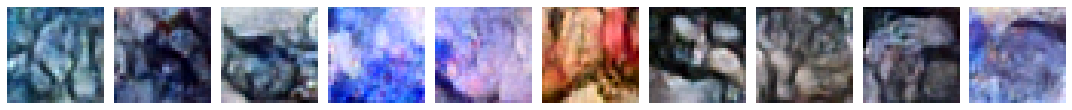


Processing class 43...
Found 43 real examples
Training for 91 epochs on 43 images...
Epoch 1/91, Loss: 0.0663
Epoch 31/91, Loss: 0.0328
Epoch 61/91, Loss: 0.0466
Epoch 91/91, Loss: 0.0539
Generating 457 new images for class 43


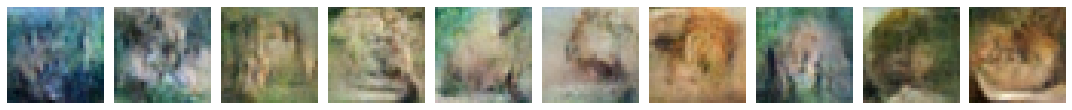


Processing class 45...
Found 31 real examples
Training for 93 epochs on 31 images...
Epoch 1/93, Loss: 0.1022
Epoch 31/93, Loss: 0.0574
Epoch 61/93, Loss: 0.0685
Epoch 91/93, Loss: 0.0698
Epoch 93/93, Loss: 0.0942
Generating 469 new images for class 45


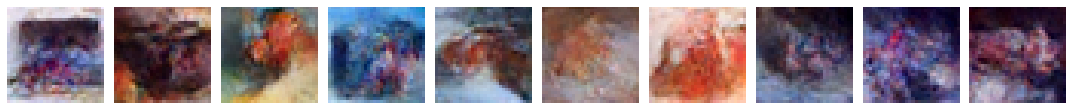


Processing class 47...
Found 39 real examples
Training for 92 epochs on 39 images...
Epoch 1/92, Loss: 0.0443
Epoch 31/92, Loss: 0.0267
Epoch 61/92, Loss: 0.0327
Epoch 91/92, Loss: 0.0415
Epoch 92/92, Loss: 0.0491
Generating 461 new images for class 47


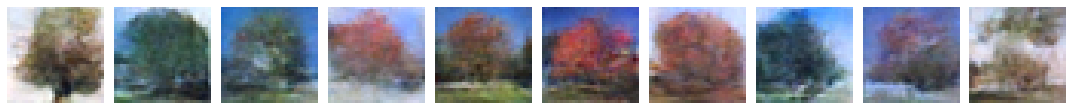


Processing class 48...
Found 89 real examples
Training for 82 epochs on 89 images...
Epoch 1/82, Loss: 0.0918
Epoch 31/82, Loss: 0.0686
Epoch 61/82, Loss: 0.0685
Epoch 82/82, Loss: 0.0546
Generating 411 new images for class 48


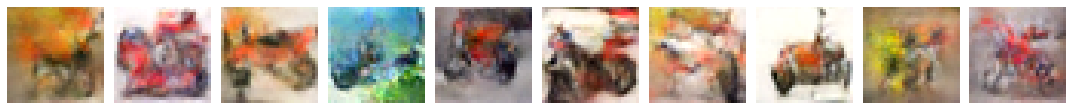


Processing class 52...
Found 56 real examples
Training for 88 epochs on 56 images...
Epoch 1/88, Loss: 0.0790
Epoch 31/88, Loss: 0.0510
Epoch 61/88, Loss: 0.0426
Epoch 88/88, Loss: 0.0355
Generating 444 new images for class 52


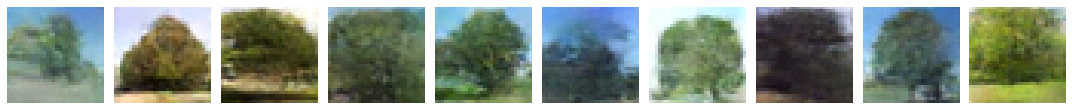


Processing class 54...
Found 29 real examples
Training for 94 epochs on 29 images...
Epoch 1/94, Loss: 0.0810
Epoch 31/94, Loss: 0.0425
Epoch 61/94, Loss: 0.0503
Epoch 91/94, Loss: 0.0473
Epoch 94/94, Loss: 0.0379
Generating 471 new images for class 54


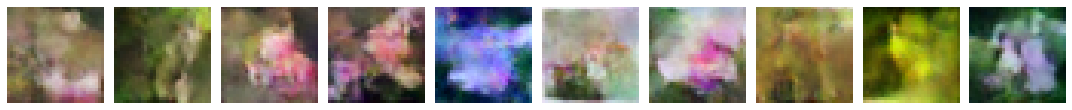


Processing class 55...
Found 61 real examples
Training for 87 epochs on 61 images...
Epoch 1/87, Loss: 0.0720
Epoch 31/87, Loss: 0.0297
Epoch 61/87, Loss: 0.0546
Epoch 87/87, Loss: 0.0410
Generating 439 new images for class 55


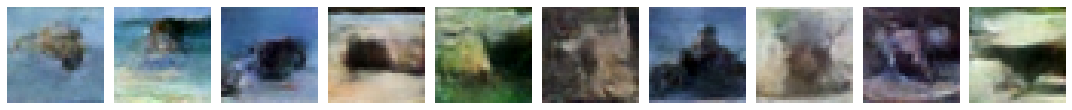


Processing class 56...
Found 83 real examples
Training for 83 epochs on 83 images...
Epoch 1/83, Loss: 0.0517
Epoch 31/83, Loss: 0.0551
Epoch 61/83, Loss: 0.0399
Epoch 83/83, Loss: 0.0405
Generating 417 new images for class 56


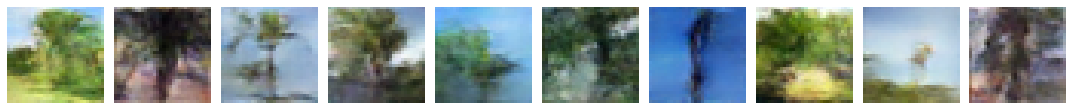


Processing class 57...
Found 30 real examples
Training for 94 epochs on 30 images...
Epoch 1/94, Loss: 0.0806
Epoch 31/94, Loss: 0.0867
Epoch 61/94, Loss: 0.0382
Epoch 91/94, Loss: 0.0714
Epoch 94/94, Loss: 0.0360
Generating 470 new images for class 57


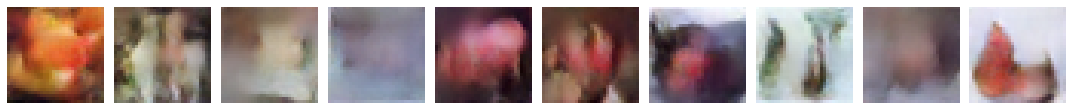


Processing class 59...
Found 67 real examples
Training for 86 epochs on 67 images...
Epoch 1/86, Loss: 0.0608
Epoch 31/86, Loss: 0.0682
Epoch 61/86, Loss: 0.0429
Epoch 86/86, Loss: 0.0449
Generating 433 new images for class 59


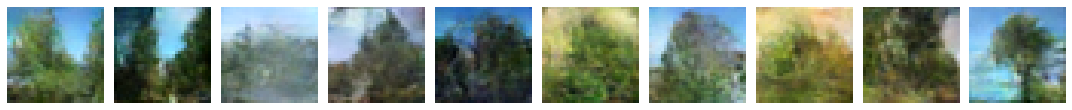


Processing class 61...
Found 41 real examples
Training for 91 epochs on 41 images...
Epoch 1/91, Loss: 0.0448
Epoch 31/91, Loss: 0.0337
Epoch 61/91, Loss: 0.0230
Epoch 91/91, Loss: 0.0337
Generating 459 new images for class 61


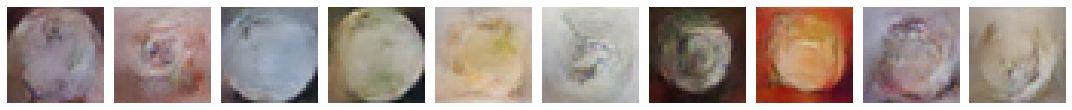


Processing class 63...
Found 50 real examples
Training for 90 epochs on 50 images...
Epoch 1/90, Loss: 0.0698
Epoch 31/90, Loss: 0.0773
Epoch 61/90, Loss: 0.0383
Epoch 90/90, Loss: 0.0554
Generating 450 new images for class 63


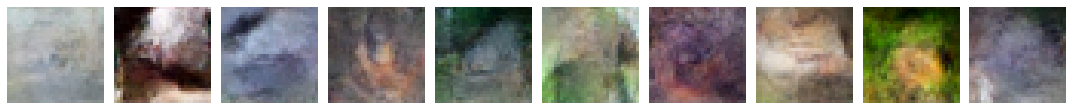


Processing class 66...
Found 51 real examples
Training for 89 epochs on 51 images...
Epoch 1/89, Loss: 0.0547
Epoch 31/89, Loss: 0.0401
Epoch 61/89, Loss: 0.0406
Epoch 89/89, Loss: 0.0980
Generating 449 new images for class 66


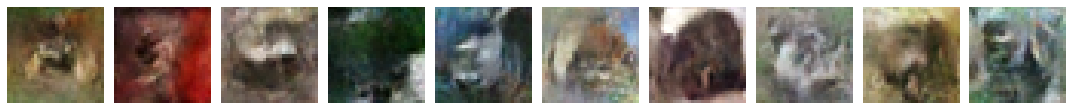


Processing class 70...
Found 25 real examples
Training for 95 epochs on 25 images...
Epoch 1/95, Loss: 0.0919
Epoch 31/95, Loss: 0.0289
Epoch 61/95, Loss: 0.0287
Epoch 91/95, Loss: 0.0565
Epoch 95/95, Loss: 0.0703
Generating 475 new images for class 70


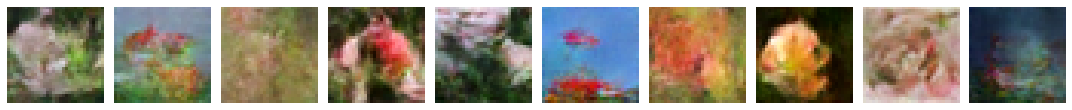


Processing class 76...
Found 91 real examples
Training for 81 epochs on 91 images...
Epoch 1/81, Loss: 0.0625
Epoch 31/81, Loss: 0.0415
Epoch 61/81, Loss: 0.0442
Epoch 81/81, Loss: 0.0352
Generating 409 new images for class 76


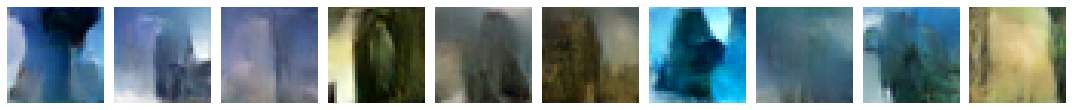


Processing class 80...
Found 72 real examples
Training for 85 epochs on 72 images...
Epoch 1/85, Loss: 0.0625
Epoch 31/85, Loss: 0.0384
Epoch 61/85, Loss: 0.0521
Epoch 85/85, Loss: 0.0437
Generating 428 new images for class 80


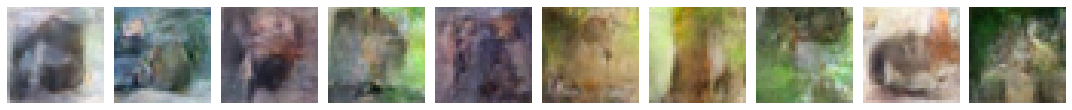


Processing class 81...
Found 29 real examples
Training for 94 epochs on 29 images...
Epoch 1/94, Loss: 0.0494
Epoch 31/94, Loss: 0.0429
Epoch 61/94, Loss: 0.0553
Epoch 91/94, Loss: 0.0363
Epoch 94/94, Loss: 0.0612
Generating 471 new images for class 81


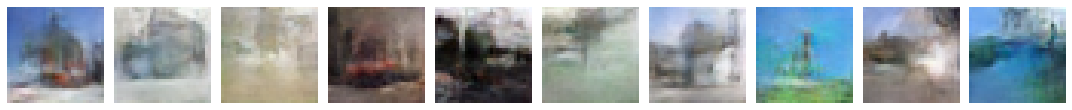


Processing class 85...
Found 26 real examples
Training for 94 epochs on 26 images...
Epoch 1/94, Loss: 0.0627
Epoch 31/94, Loss: 0.0311
Epoch 61/94, Loss: 0.0359
Epoch 91/94, Loss: 0.0362
Epoch 94/94, Loss: 0.0419
Generating 474 new images for class 85


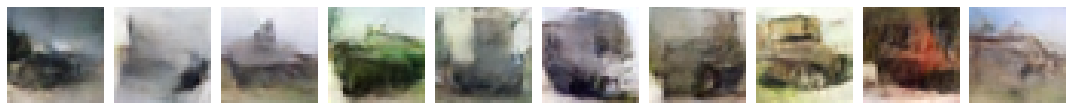


Processing class 86...
Found 27 real examples
Training for 94 epochs on 27 images...
Epoch 1/94, Loss: 0.0359
Epoch 31/94, Loss: 0.0690
Epoch 61/94, Loss: 0.0454
Epoch 91/94, Loss: 0.0307
Epoch 94/94, Loss: 0.0198
Generating 473 new images for class 86


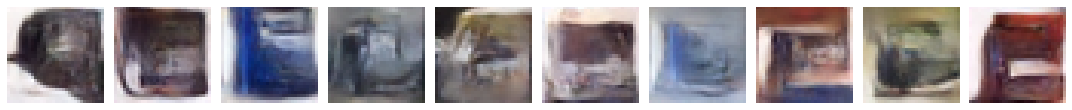


Processing class 87...
Found 74 real examples
Training for 85 epochs on 74 images...
Epoch 1/85, Loss: 0.0914
Epoch 31/85, Loss: 0.0515
Epoch 61/85, Loss: 0.0339
Epoch 85/85, Loss: 0.0321
Generating 426 new images for class 87


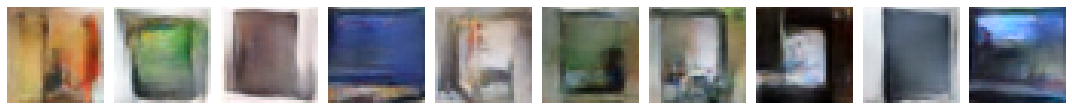


Processing class 89...
Found 37 real examples
Training for 92 epochs on 37 images...
Epoch 1/92, Loss: 0.0642
Epoch 31/92, Loss: 0.0886
Epoch 61/92, Loss: 0.0567
Epoch 91/92, Loss: 0.0420
Epoch 92/92, Loss: 0.0473
Generating 463 new images for class 89


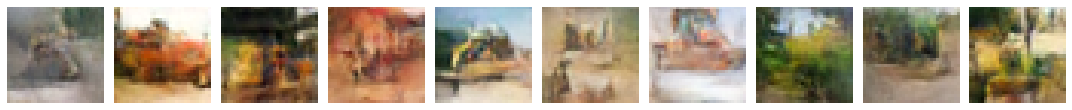


Processing class 90...
Found 28 real examples
Training for 94 epochs on 28 images...
Epoch 1/94, Loss: 0.0675
Epoch 31/94, Loss: 0.0637
Epoch 61/94, Loss: 0.0375
Epoch 91/94, Loss: 0.0531
Epoch 94/94, Loss: 0.0439
Generating 472 new images for class 90


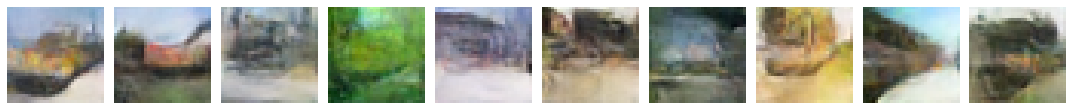


Processing class 92...
Found 54 real examples
Training for 89 epochs on 54 images...
Epoch 1/89, Loss: 0.0753
Epoch 31/89, Loss: 0.0872
Epoch 61/89, Loss: 0.0615
Epoch 89/89, Loss: 0.0687
Generating 446 new images for class 92


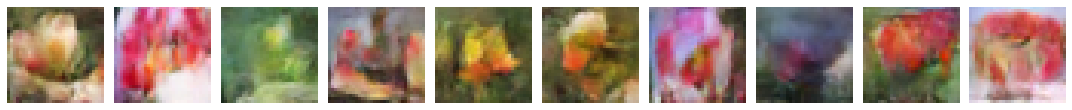


Processing class 93...
Found 38 real examples
Training for 92 epochs on 38 images...
Epoch 1/92, Loss: 0.0719
Epoch 31/92, Loss: 0.0338
Epoch 61/92, Loss: 0.0258
Epoch 91/92, Loss: 0.0482
Epoch 92/92, Loss: 0.0152
Generating 462 new images for class 93


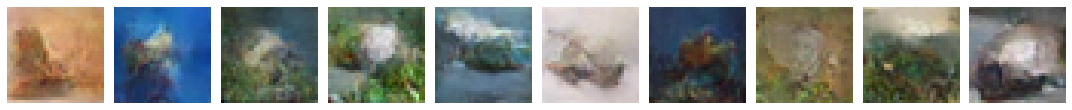

Generated 20566 images across 46 classes
Original dataset size: 15907
Generated dataset size: 36473
Class distribution after generation:
Class 0: 65 → 500
Class 1: 76 → 500
Class 2: 53 → 500
Class 5: 40 → 500
Class 6: 86 → 500
Class 9: 63 → 500
Class 11: 34 → 500
Class 12: 78 → 500
Class 14: 25 → 500
Class 16: 69 → 500
Class 18: 81 → 500
Class 19: 45 → 500
Class 21: 48 → 500
Class 23: 58 → 500
Class 27: 94 → 500
Class 28: 44 → 500
Class 32: 35 → 500
Class 33: 33 → 500
Class 34: 60 → 500
Class 35: 32 → 500
Class 36: 47 → 500
Class 39: 97 → 500
Class 43: 43 → 500
Class 45: 31 → 500
Class 47: 39 → 500
Class 48: 89 → 500
Class 52: 56 → 500
Class 54: 29 → 500
Class 55: 61 → 500
Class 56: 83 → 500
Class 57: 30 → 500
Class 59: 67 → 500
Class 61: 41 → 500
Class 63: 50 → 500
Class 66: 51 → 500
Class 70: 25 → 500
Class 76: 91 → 500
Class 80: 72 → 500
Class 81: 29 → 500
Class 85: 26 → 500
Class 86: 27 → 500
Class 87: 74 → 500
Class 89: 37 → 500
Class 90: 28 → 500
Class 92: 54 → 500
Class 93: 38 →

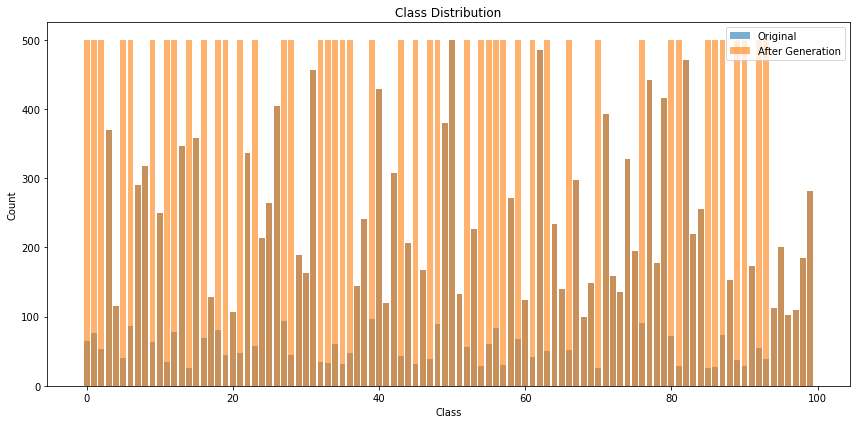

In [113]:
def generate_images_for_tail_classes(train_data, train_labels, long_tail_classes, device,
                                    num_images_target=500, min_epochs=20, max_epochs=100,
                                    batch_size=5, timesteps=500, verbose=1, save_models=False):
    """
    Generate synthetic images for tail classes in CIFAR-100

    Args:
    - train_data: CIFAR-100 training data (n, 3, 32, 32)
    - train_labels: CIFAR-100 training labels (n,)
    - long_tail_classes: List of class indices for tail classes
    - device: Torch device
    - num_images_target: Target number of images per class
    - min_epochs: Minimum number of training epochs
    - max_epochs: Maximum number of training epochs
    - batch_size: Batch size for training and generation
    - timesteps: Number of diffusion timesteps
    - verbose: 3 - class loss plots, 2 - visualize samples, 1 - print lines, 0 - no output
    - save_models: Whether or not to save the trained model

    Returns:
    - Dictionary mapping class indices to arrays of generated images
    """
    generator = DiffusionGenerator(
        device=device,
        timesteps=timesteps,
        image_size=32,
        batch_size=batch_size
    )

    generated_images = {}
    generated_labels = []
    for class_idx in long_tail_classes:
        if verbose > 0:
            print(f"\nProcessing class {class_idx}...")

        mask = train_labels == class_idx
        class_examples = train_data[mask]
        num_examples = len(class_examples)
        
        if verbose > 0:
            print(f"Found {num_examples} real examples")

        if num_examples >= num_images_target:
            if verbose > 0:
                print(f"Class {class_idx} already has {num_examples} examples, skipping.")
            continue

        num_epochs = max(min_epochs, int(max_epochs * (1 - num_examples/num_images_target)))
        
        # train diffusion model on this class
        generator.train(class_examples, epochs=num_epochs, lr=1e-4, verbose=verbose)

        # generate synthetic images
        num_to_generate = num_images_target - num_examples
        if verbose > 0:
            print(f"Generating {num_to_generate} new images for class {class_idx}")
            
        # generate without saving to disk
        synthetic_images = generator.generate_images(
            num_images=num_to_generate,
            class_idx=class_idx
        )

        # visualize loss and samples if verbose
        if verbose > 2:
            generator.plot_training_loss()
        if verbose > 1:
            generator.visualize_samples(10)

        generated_images[class_idx] = synthetic_images
        generated_labels.extend([class_idx] * num_to_generate)

        # save model if requested
        if save_models:
            import os
            save_dir = "models"
            os.makedirs(save_dir, exist_ok=True)
            generator.save_model(f"{save_dir}/diffusion_model_class_{class_idx}.pt")

    if generated_images:
        all_generated_images = np.concatenate([img for img in generated_images.values()], axis=0)
        all_generated_labels = np.array(generated_labels)
        print(f"Generated {len(all_generated_labels)} images across {len(generated_images)} classes")
        return all_generated_images, all_generated_labels
    else:
        print("No images were generated")
        return None, None

def run_generation_pipeline(trainDataLT, trainLabelLT, threshold=100, verbose=1, save_models=False):
    """
    Complete pipeline for generating images for long-tail CIFAR-100 classes

    Args:
    - trainDataLT: long-tail CIFAR-100 training data
    - trainLabelLT: long-tail CIFAR-100 training labels
    - threshold: Classes with fewer than this many samples are considered tail classes
    - verbose: 2 - class distribution, 1 - print lines, 0 - no output
    - save_models: Whether or not to save the trained model

    Returns:
    - Augmented dataset with synthetic images
    """
    class_counts = np.bincount(trainLabelLT, minlength=100)
    long_tail_classes = np.where(class_counts < threshold)[0]
    
    if verbose > 0:
        print(f"Identified {len(long_tail_classes)} long-tail classes with fewer than {threshold} samples:")
        print(long_tail_classes)

    # Generate images
    synthetic_images, synthetic_labels = generate_images_for_tail_classes(
        trainDataLT, trainLabelLT, long_tail_classes, device,
        num_images_target=500,
        min_epochs=20,
        max_epochs=100,
        batch_size=16,
        timesteps=500,
        verbose=verbose,
        save_models=save_models
    )
    
    if synthetic_images is not None:
        # Check if trainDataLT is in [0,255] range
        if trainDataLT.max() > 1.0:
            # Scale generated images to match original data
            synthetic_images = synthetic_images * 255.0
            
        generated_data = np.concatenate([trainDataLT, synthetic_images], axis=0)
        generated_labels = np.concatenate([trainLabelLT, synthetic_labels], axis=0)

        if verbose > 0:
            print(f"Original dataset size: {len(trainDataLT)}")
            print(f"Generated dataset size: {len(generated_data)}")

            # Check class distribution if verbose
            if verbose > 1:
                generated_class_counts = np.bincount(generated_labels, minlength=100)
                print("Class distribution after generation:")
                for i, count in enumerate(generated_class_counts):
                    if i in long_tail_classes:
                        print(f"Class {i}: {class_counts[i]} → {count}")

                # Visualize distributions
                plt.figure(figsize=(12, 6))
                plt.bar(range(100), class_counts, alpha=0.6, label='Original')
                plt.bar(range(100), generated_class_counts, alpha=0.6, label='After Generation')
                plt.xlabel('Class')
                plt.ylabel('Count')
                plt.title('Class Distribution')
                plt.legend()
                plt.tight_layout()
                plt.show()

        return generated_data, generated_labels
    else:
        return trainDataLT, trainLabelLT

generatedLT, generatedLabelLT = run_generation_pipeline(trainDataLT, trainLabelLT, threshold=100, verbose=2)

(36473, 3, 32, 32) (36473,)


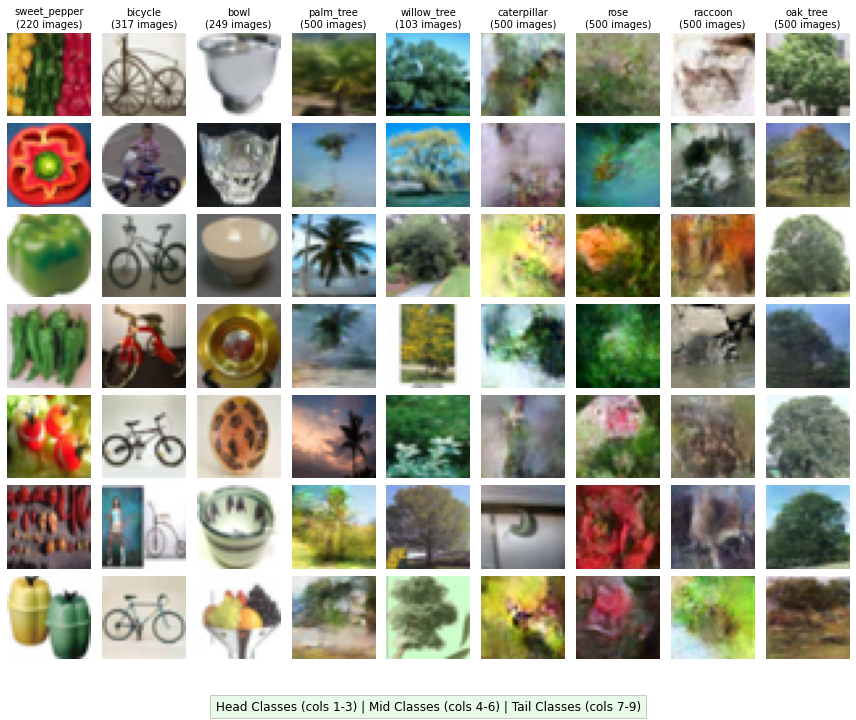

In [114]:
print(generatedLT.shape, generatedLabelLT.shape)
visualize_long_tail_classes(generatedLT, generatedLabelLT, clsList, classLabels)

1140it [00:27, 41.12it/s]


Test Accuracy - Overall: 3.60% | Head: 3.04% | Mid: 2.06% | Tail: 6.28%
Epoch 1/20 completed: val acc=0.036, train acc=0.043, epoch loss=4.426


1140it [00:27, 41.08it/s]


Test Accuracy - Overall: 5.83% | Head: 13.08% | Mid: 3.30% | Tail: 1.78%
Epoch 2/20 completed: val acc=0.058, train acc=0.126, epoch loss=3.664


1140it [00:28, 39.98it/s]


Test Accuracy - Overall: 11.00% | Head: 18.67% | Mid: 8.66% | Tail: 6.28%
Epoch 3/20 completed: val acc=0.110, train acc=0.265, epoch loss=2.920


1140it [00:27, 40.88it/s]


Test Accuracy - Overall: 14.52% | Head: 25.99% | Mid: 12.27% | Tail: 5.77%
Epoch 4/20 completed: val acc=0.145, train acc=0.408, epoch loss=2.300


1140it [00:27, 40.72it/s]


Test Accuracy - Overall: 17.97% | Head: 33.39% | Mid: 14.83% | Tail: 6.36%
Epoch 5/20 completed: val acc=0.180, train acc=0.495, epoch loss=1.934


1140it [00:27, 41.91it/s]


Test Accuracy - Overall: 20.93% | Head: 35.28% | Mid: 20.93% | Tail: 6.11%
Epoch 6/20 completed: val acc=0.209, train acc=0.566, epoch loss=1.630


1140it [00:27, 41.31it/s]


Test Accuracy - Overall: 26.02% | Head: 39.72% | Mid: 25.67% | Tail: 12.38%
Epoch 7/20 completed: val acc=0.260, train acc=0.624, epoch loss=1.400


1140it [00:27, 41.87it/s]


Test Accuracy - Overall: 24.82% | Head: 39.72% | Mid: 24.24% | Tail: 10.26%
Epoch 8/20 completed: val acc=0.248, train acc=0.677, epoch loss=1.191


1140it [00:26, 43.56it/s]


Test Accuracy - Overall: 27.90% | Head: 44.90% | Mid: 27.04% | Tail: 11.54%
Epoch 9/20 completed: val acc=0.279, train acc=0.721, epoch loss=1.006


1140it [00:28, 40.66it/s]


Test Accuracy - Overall: 28.30% | Head: 43.83% | Mid: 25.48% | Tail: 16.12%
Epoch 10/20 completed: val acc=0.283, train acc=0.766, epoch loss=0.822


1140it [00:28, 40.11it/s]


Test Accuracy - Overall: 31.57% | Head: 46.96% | Mid: 33.21% | Tail: 13.49%
Epoch 11/20 completed: val acc=0.316, train acc=0.813, epoch loss=0.645


1140it [00:26, 43.19it/s]


Test Accuracy - Overall: 31.57% | Head: 50.08% | Mid: 31.15% | Tail: 13.06%
Epoch 12/20 completed: val acc=0.316, train acc=0.863, epoch loss=0.454


1140it [00:26, 42.86it/s]


Test Accuracy - Overall: 31.67% | Head: 49.92% | Mid: 32.71% | Tail: 11.45%
Epoch 13/20 completed: val acc=0.317, train acc=0.918, epoch loss=0.270


1140it [00:26, 42.55it/s]


Test Accuracy - Overall: 32.07% | Head: 48.77% | Mid: 34.27% | Tail: 11.87%
Epoch 14/20 completed: val acc=0.321, train acc=0.957, epoch loss=0.147


1140it [00:26, 43.21it/s]


Test Accuracy - Overall: 32.48% | Head: 47.86% | Mid: 35.08% | Tail: 13.06%
Epoch 15/20 completed: val acc=0.325, train acc=0.984, epoch loss=0.068


1140it [00:26, 42.73it/s]


Test Accuracy - Overall: 33.77% | Head: 50.00% | Mid: 36.07% | Tail: 13.91%
Epoch 16/20 completed: val acc=0.338, train acc=0.993, epoch loss=0.037


1140it [00:25, 44.27it/s]


Test Accuracy - Overall: 33.00% | Head: 50.08% | Mid: 35.02% | Tail: 12.64%
Epoch 17/20 completed: val acc=0.330, train acc=0.997, epoch loss=0.020


1140it [00:26, 43.68it/s]


Test Accuracy - Overall: 33.45% | Head: 51.81% | Mid: 35.45% | Tail: 11.79%
Epoch 18/20 completed: val acc=0.335, train acc=0.998, epoch loss=0.013


1140it [00:26, 43.15it/s]


Test Accuracy - Overall: 33.15% | Head: 50.82% | Mid: 35.02% | Tail: 12.38%
Epoch 19/20 completed: val acc=0.332, train acc=0.999, epoch loss=0.010


1140it [00:26, 42.37it/s]


Test Accuracy - Overall: 33.17% | Head: 51.64% | Mid: 34.83% | Tail: 11.87%
Epoch 20/20 completed: val acc=0.332, train acc=0.999, epoch loss=0.007


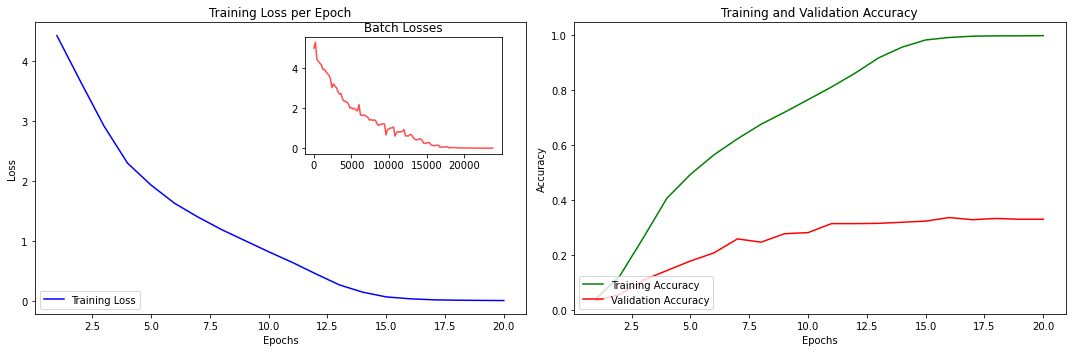

In [134]:
# Cifar-100 Generated LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
lossesGenLT, trainAccGenLT, valAccGenLT = train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

# DINO Implementation

## Dino/Data Setup

In [115]:
dinoTransform =  transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.4, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

def dinoAugment(baseImg):
    img = Image.fromarray(np.transpose(baseImg, (1, 2, 0)).astype(np.uint8))
    imgAug = dinoTransform(img)
    return imgAug

In [116]:
tempImages = [dinoAugment(img) for img in trainDataLT]
tempImages = torch.stack(tempImages)
dinoImage1 = tempImages.numpy()

tempImages = [dinoAugment(img) for img in trainDataLT]
tempImages = torch.stack(tempImages)
dinoImage2 = tempImages.numpy()

In [117]:
dinoData = torch.utils.data.TensorDataset(torch.tensor(dinoImage1, dtype=torch.float32),
                                          torch.tensor(dinoImage2, dtype=torch.float32))
dinoLoader = torch.utils.data.DataLoader(dinoData, batch_size=128, shuffle=True)

In [118]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim=65536, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        self.last_layer.weight_g.requires_grad = False  # Freeze the norm

    def forward(self, x):
        x = self.mlp(x)
        return self.last_layer(x)

In [119]:
def dino_loss(student_out, teacher_out, temp_student=0.1, temp_teacher=0.07):
    student_out = torch.nn.functional.log_softmax(student_out / temp_student, dim=-1)
    teacher_out = torch.nn.functional.softmax((teacher_out / temp_teacher).detach(), dim=-1)
    return -torch.mean(torch.sum(teacher_out * student_out, dim=-1))

## Dino Resnet18

In [120]:
class DINOBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

In [121]:
studentBackbone = DINOBackbone()
teacherBackbone = DINOBackbone()

studentHead = DINOHead(in_dim=512)
teacherHead = DINOHead(in_dim=512)

student = nn.Sequential(studentBackbone, studentHead)
teacher = nn.Sequential(teacherBackbone, teacherHead)

for p in teacher.parameters():
    p.requires_grad = False

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/javvaji.m/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [122]:
student = student.to(device)
teacher = teacher.to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

for epoch in range(20):
    for view1, view2 in dinoLoader:
        view1, view2 = view1.to(device), view2.to(device)

        student_out = student(view1)
        with torch.no_grad():
            teacher_out = teacher(view2)

        loss = dino_loss(student_out, teacher_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update of teacher
        with torch.no_grad():
            m = 0.996  # Momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data = param_k.data * m + param_q.data * (1. - m)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

torch.save(studentBackbone.state_dict(), "dinoBackbone.pth")


Epoch 1, Loss: 10.3344
Epoch 2, Loss: 9.9596
Epoch 3, Loss: 9.2700
Epoch 4, Loss: 7.9337
Epoch 5, Loss: 5.9504
Epoch 6, Loss: 1.9398
Epoch 7, Loss: 0.9083
Epoch 8, Loss: 0.3361
Epoch 9, Loss: 0.1117
Epoch 10, Loss: 0.0387
Epoch 11, Loss: 0.0130
Epoch 12, Loss: 0.0037
Epoch 13, Loss: 0.0009
Epoch 14, Loss: 0.0002
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000


In [123]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

498it [00:05, 86.38it/s]


Test Accuracy - Overall: 10.82% | Head: 25.16% | Mid: 6.92% | Tail: 1.36%
Epoch 1/20 completed: val acc=0.108, train acc=0.123, epoch loss=3.821


498it [00:05, 84.31it/s]


Test Accuracy - Overall: 14.70% | Head: 32.07% | Mid: 10.47% | Tail: 2.54%
Epoch 2/20 completed: val acc=0.147, train acc=0.233, epoch loss=3.182


498it [00:05, 87.47it/s]


Test Accuracy - Overall: 18.27% | Head: 35.28% | Mid: 16.95% | Tail: 2.54%
Epoch 3/20 completed: val acc=0.183, train acc=0.313, epoch loss=2.781


498it [00:06, 82.08it/s]


Test Accuracy - Overall: 19.38% | Head: 35.20% | Mid: 19.75% | Tail: 2.54%
Epoch 4/20 completed: val acc=0.194, train acc=0.381, epoch loss=2.439


498it [00:05, 90.60it/s]


Test Accuracy - Overall: 20.42% | Head: 36.92% | Mid: 20.12% | Tail: 3.82%
Epoch 5/20 completed: val acc=0.204, train acc=0.453, epoch loss=2.110


498it [00:06, 80.72it/s]


Test Accuracy - Overall: 22.10% | Head: 38.16% | Mid: 21.99% | Tail: 5.68%
Epoch 6/20 completed: val acc=0.221, train acc=0.531, epoch loss=1.784


498it [00:06, 80.62it/s]


Test Accuracy - Overall: 23.33% | Head: 40.21% | Mid: 23.93% | Tail: 5.09%
Epoch 7/20 completed: val acc=0.233, train acc=0.620, epoch loss=1.458


498it [00:05, 93.01it/s]


Test Accuracy - Overall: 22.62% | Head: 39.72% | Mid: 22.18% | Tail: 5.60%
Epoch 8/20 completed: val acc=0.226, train acc=0.699, epoch loss=1.162


498it [00:05, 92.95it/s]


Test Accuracy - Overall: 23.93% | Head: 39.64% | Mid: 23.80% | Tail: 7.89%
Epoch 9/20 completed: val acc=0.239, train acc=0.768, epoch loss=0.921


498it [00:05, 90.11it/s]


Test Accuracy - Overall: 23.23% | Head: 38.32% | Mid: 23.61% | Tail: 7.12%
Epoch 10/20 completed: val acc=0.232, train acc=0.850, epoch loss=0.654


498it [00:05, 88.79it/s]


Test Accuracy - Overall: 22.68% | Head: 39.14% | Mid: 21.37% | Tail: 7.46%
Epoch 11/20 completed: val acc=0.227, train acc=0.868, epoch loss=0.576


498it [00:06, 81.87it/s]


Test Accuracy - Overall: 23.03% | Head: 38.90% | Mid: 22.12% | Tail: 7.89%
Epoch 12/20 completed: val acc=0.230, train acc=0.923, epoch loss=0.407


498it [00:05, 84.29it/s]


Test Accuracy - Overall: 23.65% | Head: 38.73% | Mid: 23.93% | Tail: 7.72%
Epoch 13/20 completed: val acc=0.236, train acc=0.932, epoch loss=0.367


498it [00:06, 81.21it/s]


Test Accuracy - Overall: 23.75% | Head: 38.65% | Mid: 23.68% | Tail: 8.48%
Epoch 14/20 completed: val acc=0.237, train acc=0.964, epoch loss=0.247


498it [00:06, 80.02it/s]


Test Accuracy - Overall: 23.80% | Head: 39.14% | Mid: 23.80% | Tail: 7.97%
Epoch 15/20 completed: val acc=0.238, train acc=0.965, epoch loss=0.235


498it [00:06, 79.25it/s]


Test Accuracy - Overall: 24.07% | Head: 40.05% | Mid: 23.74% | Tail: 8.06%
Epoch 16/20 completed: val acc=0.241, train acc=0.975, epoch loss=0.195


498it [00:05, 94.04it/s] 


Test Accuracy - Overall: 23.67% | Head: 38.73% | Mid: 23.93% | Tail: 7.80%
Epoch 17/20 completed: val acc=0.237, train acc=0.982, epoch loss=0.167


498it [00:06, 82.75it/s]


Test Accuracy - Overall: 24.60% | Head: 39.80% | Mid: 24.61% | Tail: 8.91%
Epoch 18/20 completed: val acc=0.246, train acc=0.983, epoch loss=0.158


498it [00:05, 91.27it/s]


Test Accuracy - Overall: 24.60% | Head: 40.95% | Mid: 24.11% | Tail: 8.40%
Epoch 19/20 completed: val acc=0.246, train acc=0.986, epoch loss=0.143


498it [00:05, 92.20it/s] 


Test Accuracy - Overall: 24.20% | Head: 40.21% | Mid: 24.30% | Tail: 7.55%
Epoch 20/20 completed: val acc=0.242, train acc=0.985, epoch loss=0.149


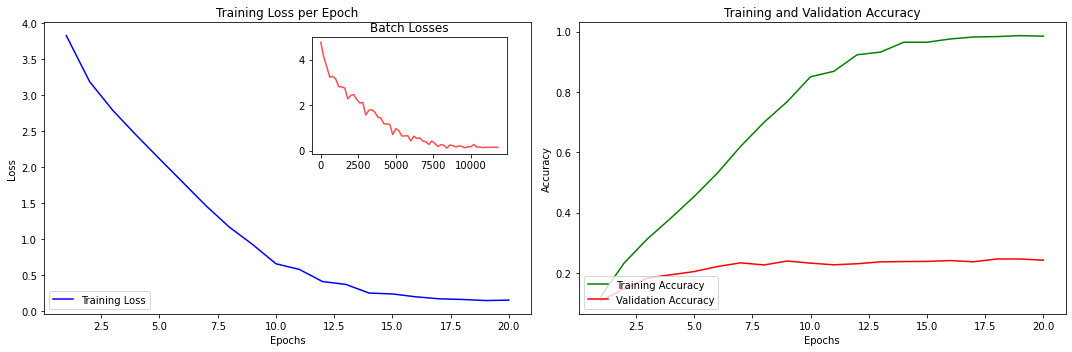

([3.820567301957004,
  3.1821343065744423,
  2.781259683720079,
  2.439339311726122,
  2.1098562388056252,
  1.7844735733476509,
  1.4580985138933342,
  1.1623875078666641,
  0.9207803225780586,
  0.6537980957024069,
  0.5759158414231247,
  0.4068457448638108,
  0.3669790248255653,
  0.2471963623950041,
  0.234531331912102,
  0.19534772770651374,
  0.16745927836371952,
  0.1584299494508639,
  0.14306310811884193,
  0.1491520394118555],
 [0.1225875400766958,
  0.23297919155088956,
  0.3129439869239957,
  0.38140441315144274,
  0.4529452442320991,
  0.5307097504243414,
  0.6195385679260703,
  0.6989375746526686,
  0.7677123279059533,
  0.8501288740805935,
  0.8681083799585089,
  0.922989878669768,
  0.931791035393223,
  0.9644181806751745,
  0.9645439114855096,
  0.9753567611743258,
  0.981831897906582,
  0.9832149368202678,
  0.9863582070786446,
  0.9845979757339536],
 [0.10825,
  0.147,
  0.18275,
  0.19375,
  0.20425,
  0.221,
  0.23325,
  0.22625,
  0.23925,
  0.23225,
  0.22675,
  0

In [124]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
995it [00:12, 81.92it/s]


Test Accuracy - Overall: 8.33% | Head: 21.63% | Mid: 4.11% | Tail: 0.34%
Epoch 1/20 completed: val acc=0.083, train acc=0.085, epoch loss=4.005


995it [00:11, 85.69it/s]


Test Accuracy - Overall: 14.55% | Head: 31.09% | Mid: 11.09% | Tail: 2.21%
Epoch 2/20 completed: val acc=0.145, train acc=0.144, epoch loss=3.623


995it [00:10, 92.22it/s]


Test Accuracy - Overall: 16.73% | Head: 34.29% | Mid: 13.83% | Tail: 2.54%
Epoch 3/20 completed: val acc=0.167, train acc=0.182, epoch loss=3.419


995it [00:10, 92.49it/s]


Test Accuracy - Overall: 20.08% | Head: 38.40% | Mid: 19.13% | Tail: 2.46%
Epoch 4/20 completed: val acc=0.201, train acc=0.217, epoch loss=3.231


995it [00:12, 81.74it/s]


Test Accuracy - Overall: 21.30% | Head: 38.98% | Mid: 20.69% | Tail: 3.90%
Epoch 5/20 completed: val acc=0.213, train acc=0.254, epoch loss=3.065


995it [00:10, 96.64it/s] 


Test Accuracy - Overall: 22.07% | Head: 37.66% | Mid: 21.99% | Tail: 6.11%
Epoch 6/20 completed: val acc=0.221, train acc=0.289, epoch loss=2.884


995it [00:10, 90.52it/s]


Test Accuracy - Overall: 21.93% | Head: 38.32% | Mid: 21.43% | Tail: 5.68%
Epoch 7/20 completed: val acc=0.219, train acc=0.334, epoch loss=2.675


995it [00:10, 91.70it/s]


Test Accuracy - Overall: 23.47% | Head: 39.14% | Mid: 24.61% | Tail: 5.77%
Epoch 8/20 completed: val acc=0.235, train acc=0.375, epoch loss=2.497


995it [00:11, 84.54it/s] 


Test Accuracy - Overall: 24.15% | Head: 37.42% | Mid: 25.92% | Tail: 8.06%
Epoch 9/20 completed: val acc=0.241, train acc=0.418, epoch loss=2.333


995it [00:10, 90.93it/s]


Test Accuracy - Overall: 24.55% | Head: 40.13% | Mid: 24.80% | Tail: 8.14%
Epoch 10/20 completed: val acc=0.245, train acc=0.460, epoch loss=2.176


995it [00:11, 85.28it/s]


Test Accuracy - Overall: 24.65% | Head: 40.13% | Mid: 24.98% | Tail: 8.23%
Epoch 11/20 completed: val acc=0.246, train acc=0.497, epoch loss=2.038


995it [00:11, 89.69it/s] 


Test Accuracy - Overall: 23.97% | Head: 39.80% | Mid: 24.55% | Tail: 6.87%
Epoch 12/20 completed: val acc=0.240, train acc=0.529, epoch loss=1.921


995it [00:10, 99.37it/s] 


Test Accuracy - Overall: 24.35% | Head: 38.98% | Mid: 25.17% | Tail: 8.14%
Epoch 13/20 completed: val acc=0.243, train acc=0.556, epoch loss=1.821


995it [00:11, 84.26it/s]


Test Accuracy - Overall: 24.15% | Head: 39.14% | Mid: 24.42% | Tail: 8.31%
Epoch 14/20 completed: val acc=0.241, train acc=0.579, epoch loss=1.740


995it [00:11, 86.69it/s]


Test Accuracy - Overall: 24.12% | Head: 38.57% | Mid: 24.92% | Tail: 8.14%
Epoch 15/20 completed: val acc=0.241, train acc=0.593, epoch loss=1.685


995it [00:12, 82.90it/s]


Test Accuracy - Overall: 23.30% | Head: 37.01% | Mid: 23.80% | Tail: 8.48%
Epoch 16/20 completed: val acc=0.233, train acc=0.605, epoch loss=1.635


995it [00:10, 92.73it/s]


Test Accuracy - Overall: 24.30% | Head: 38.08% | Mid: 25.92% | Tail: 7.89%
Epoch 17/20 completed: val acc=0.243, train acc=0.610, epoch loss=1.609


995it [00:11, 85.06it/s]


Test Accuracy - Overall: 24.10% | Head: 37.42% | Mid: 25.79% | Tail: 8.06%
Epoch 18/20 completed: val acc=0.241, train acc=0.618, epoch loss=1.578


995it [00:10, 90.89it/s]


Test Accuracy - Overall: 24.38% | Head: 38.98% | Mid: 25.05% | Tail: 8.40%
Epoch 19/20 completed: val acc=0.244, train acc=0.623, epoch loss=1.560


995it [00:11, 86.46it/s]


Test Accuracy - Overall: 24.32% | Head: 38.32% | Mid: 25.86% | Tail: 7.80%
Epoch 20/20 completed: val acc=0.243, train acc=0.627, epoch loss=1.548


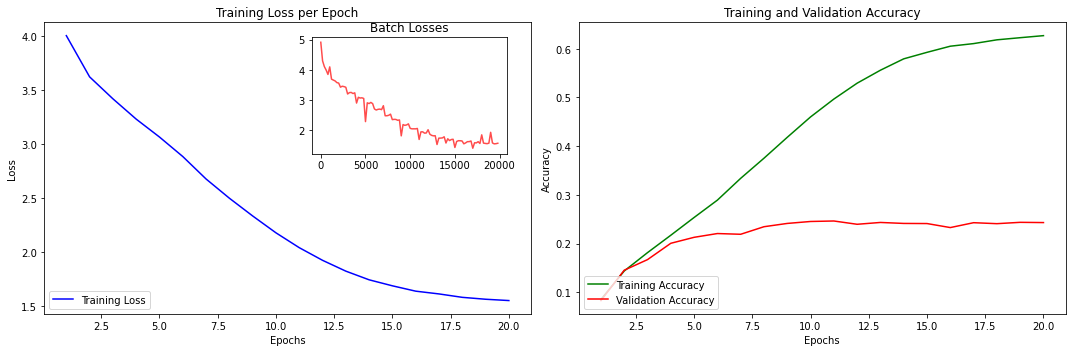

([4.005389888082917,
  3.622876912505183,
  3.419466908852659,
  3.2309213686228997,
  3.0647658908786486,
  2.8838997081296527,
  2.6754989054933866,
  2.4973836994650376,
  2.332690004727349,
  2.176220378684039,
  2.0384627695658697,
  1.921178381407081,
  1.8207306361078617,
  1.7402976570416935,
  1.6845963125252843,
  1.6349633216258868,
  1.609354590710683,
  1.577729438058096,
  1.5600107969950192,
  1.5478734203918496],
 [0.08543408562268184,
  0.1438989124284906,
  0.18158672282642863,
  0.21726284025900547,
  0.25369334255359277,
  0.28930659458100205,
  0.33403533035770416,
  0.37530646885019175,
  0.4182121078770353,
  0.4600176023134469,
  0.4966681335261206,
  0.5292638461054882,
  0.5558873451939398,
  0.5792104105110958,
  0.5925693091091973,
  0.6051423901427044,
  0.610485949581945,
  0.618218394417552,
  0.6225875400766958,
  0.6267995222229207],
 [0.08325,
  0.1455,
  0.16725,
  0.20075,
  0.213,
  0.22075,
  0.21925,
  0.23475,
  0.2415,
  0.2455,
  0.2465,
  0.23

In [125]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
1140it [00:13, 87.60it/s]


Test Accuracy - Overall: 12.50% | Head: 19.65% | Mid: 9.53% | Tail: 9.16%
Epoch 1/20 completed: val acc=0.125, train acc=0.185, epoch loss=3.490


1140it [00:11, 95.64it/s]


Test Accuracy - Overall: 17.12% | Head: 26.89% | Mid: 14.39% | Tail: 10.77%
Epoch 2/20 completed: val acc=0.171, train acc=0.405, epoch loss=2.392


1140it [00:12, 90.82it/s]


Test Accuracy - Overall: 21.02% | Head: 32.73% | Mid: 18.82% | Tail: 11.96%
Epoch 3/20 completed: val acc=0.210, train acc=0.529, epoch loss=1.844


1140it [00:12, 87.98it/s]


Test Accuracy - Overall: 21.70% | Head: 32.15% | Mid: 20.62% | Tail: 12.38%
Epoch 4/20 completed: val acc=0.217, train acc=0.615, epoch loss=1.483


1140it [00:13, 87.17it/s]


Test Accuracy - Overall: 23.18% | Head: 33.39% | Mid: 22.74% | Tail: 13.23%
Epoch 5/20 completed: val acc=0.232, train acc=0.688, epoch loss=1.174


1140it [00:13, 85.65it/s]


Test Accuracy - Overall: 23.33% | Head: 34.13% | Mid: 23.12% | Tail: 12.47%
Epoch 6/20 completed: val acc=0.233, train acc=0.753, epoch loss=0.926


1140it [00:12, 94.33it/s]


Test Accuracy - Overall: 24.77% | Head: 37.09% | Mid: 25.61% | Tail: 10.94%
Epoch 7/20 completed: val acc=0.248, train acc=0.809, epoch loss=0.709


1140it [00:12, 89.29it/s]


Test Accuracy - Overall: 23.47% | Head: 35.20% | Mid: 23.49% | Tail: 11.37%
Epoch 8/20 completed: val acc=0.235, train acc=0.865, epoch loss=0.512


1140it [00:11, 99.82it/s] 


Test Accuracy - Overall: 25.40% | Head: 39.97% | Mid: 25.05% | Tail: 10.86%
Epoch 9/20 completed: val acc=0.254, train acc=0.906, epoch loss=0.367


1140it [00:12, 89.15it/s]


Test Accuracy - Overall: 25.50% | Head: 37.83% | Mid: 25.55% | Tail: 12.72%
Epoch 10/20 completed: val acc=0.255, train acc=0.943, epoch loss=0.243


1140it [00:11, 102.43it/s]


Test Accuracy - Overall: 24.95% | Head: 37.66% | Mid: 24.74% | Tail: 12.13%
Epoch 11/20 completed: val acc=0.249, train acc=0.966, epoch loss=0.166


1140it [00:13, 86.07it/s]


Test Accuracy - Overall: 24.90% | Head: 38.16% | Mid: 25.55% | Tail: 10.35%
Epoch 12/20 completed: val acc=0.249, train acc=0.980, epoch loss=0.113


1140it [00:13, 84.92it/s] 


Test Accuracy - Overall: 25.90% | Head: 37.25% | Mid: 26.98% | Tail: 12.72%
Epoch 13/20 completed: val acc=0.259, train acc=0.988, epoch loss=0.079


1140it [00:13, 81.86it/s]


Test Accuracy - Overall: 25.50% | Head: 39.14% | Mid: 25.98% | Tail: 10.77%
Epoch 14/20 completed: val acc=0.255, train acc=0.992, epoch loss=0.058


1140it [00:13, 84.73it/s]


Test Accuracy - Overall: 25.32% | Head: 38.16% | Mid: 26.36% | Tail: 10.69%
Epoch 15/20 completed: val acc=0.253, train acc=0.994, epoch loss=0.044


1140it [00:12, 90.13it/s]


Test Accuracy - Overall: 26.10% | Head: 38.40% | Mid: 26.98% | Tail: 12.21%
Epoch 16/20 completed: val acc=0.261, train acc=0.997, epoch loss=0.032


1140it [00:12, 93.08it/s]


Test Accuracy - Overall: 26.35% | Head: 39.47% | Mid: 27.04% | Tail: 11.87%
Epoch 17/20 completed: val acc=0.264, train acc=0.998, epoch loss=0.026


1140it [00:12, 92.61it/s]


Test Accuracy - Overall: 26.00% | Head: 38.40% | Mid: 27.17% | Tail: 11.62%
Epoch 18/20 completed: val acc=0.260, train acc=0.998, epoch loss=0.022


1140it [00:12, 92.68it/s]


Test Accuracy - Overall: 26.05% | Head: 39.14% | Mid: 26.85% | Tail: 11.45%
Epoch 19/20 completed: val acc=0.261, train acc=0.999, epoch loss=0.020


1140it [00:12, 93.33it/s]


Test Accuracy - Overall: 26.20% | Head: 38.82% | Mid: 26.73% | Tail: 12.47%
Epoch 20/20 completed: val acc=0.262, train acc=0.999, epoch loss=0.018


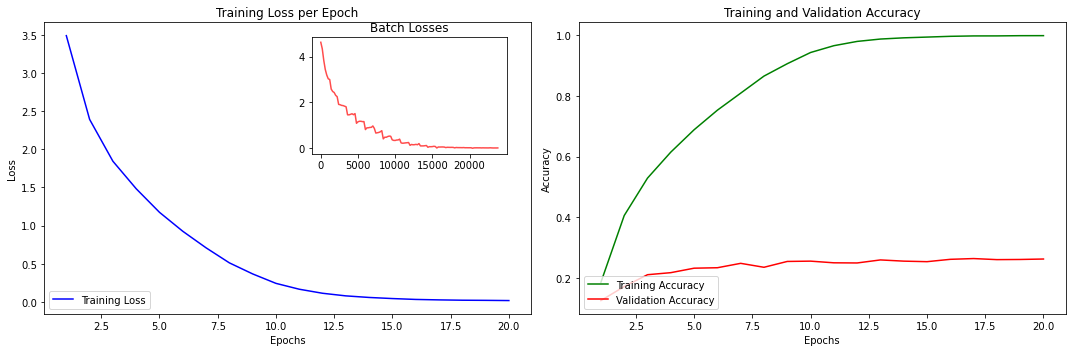

([3.490210961458976,
  2.3923137843608857,
  1.8437940455319588,
  1.4831873587871853,
  1.1742096755588263,
  0.9258293804108051,
  0.7087813843629862,
  0.5117555042369324,
  0.36677957235982545,
  0.24298039356802117,
  0.16617408778616471,
  0.11317925690183121,
  0.07894512008908286,
  0.05824856949896601,
  0.0438280109471331,
  0.03234680671154995,
  0.026369692456067066,
  0.022116054594312515,
  0.020374209289398176,
  0.017641374861143463],
 [0.18536999972582457,
  0.4054231897568064,
  0.5288843802264689,
  0.6146190332574781,
  0.6883173854632194,
  0.7528856962684726,
  0.8090642393003044,
  0.8653250349573657,
  0.9061771721547446,
  0.943136018424588,
  0.965618402654018,
  0.9797384366517699,
  0.9875524360485839,
  0.9915553971430922,
  0.9940229758999808,
  0.9965453897403559,
  0.9978340142022866,
  0.9979162668275162,
  0.9986565404545829,
  0.9987662106215557],
 [0.125,
  0.17125,
  0.21025,
  0.217,
  0.23175,
  0.23325,
  0.24775,
  0.23475,
  0.254,
  0.255,
  0

In [126]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

## Dino Resnet50

In [127]:
class DINOBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = resnet50(pretrained=False)
        self.encoder.fc = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

In [128]:
studentBackbone = DINOBackbone()
teacherBackbone = DINOBackbone()

studentHead = DINOHead(in_dim=2048)
teacherHead = DINOHead(in_dim=2048)

student = nn.Sequential(studentBackbone, studentHead)
teacher = nn.Sequential(teacherBackbone, teacherHead)

for p in teacher.parameters():
    p.requires_grad = False

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/javvaji.m/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [129]:
student = student.to(device)
teacher = teacher.to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

for epoch in range(20):
    for view1, view2 in dinoLoader:
        view1, view2 = view1.to(device), view2.to(device)

        student_out = student(view1)
        with torch.no_grad():
            teacher_out = teacher(view2)

        loss = dino_loss(student_out, teacher_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update of teacher
        with torch.no_grad():
            m = 0.996  # Momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data = param_k.data * m + param_q.data * (1. - m)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

torch.save(studentBackbone.state_dict(), "dinoBackbone1.pth")

Epoch 1, Loss: 10.5802
Epoch 2, Loss: 9.9386
Epoch 3, Loss: 8.7225
Epoch 4, Loss: 7.5613
Epoch 5, Loss: 5.1923
Epoch 6, Loss: 3.0067
Epoch 7, Loss: 1.0541
Epoch 8, Loss: 0.4659
Epoch 9, Loss: 0.1304
Epoch 10, Loss: 0.0407
Epoch 11, Loss: 0.0078
Epoch 12, Loss: 0.0029
Epoch 13, Loss: 0.0006
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000


In [130]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=100):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

498it [00:12, 39.66it/s]


Test Accuracy - Overall: 1.23% | Head: 4.03% | Mid: 0.00% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.012, train acc=0.059, epoch loss=4.872


498it [00:12, 40.64it/s]


Test Accuracy - Overall: 2.97% | Head: 9.70% | Mid: 0.06% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.030, train acc=0.060, epoch loss=4.522


498it [00:12, 39.70it/s]


Test Accuracy - Overall: 4.45% | Head: 14.64% | Mid: 0.00% | Tail: 0.00%
Epoch 3/20 completed: val acc=0.044, train acc=0.085, epoch loss=4.140


498it [00:12, 40.99it/s]


Test Accuracy - Overall: 3.88% | Head: 11.76% | Mid: 0.75% | Tail: 0.00%
Epoch 4/20 completed: val acc=0.039, train acc=0.096, epoch loss=4.055


498it [00:11, 42.35it/s]


Test Accuracy - Overall: 5.10% | Head: 15.46% | Mid: 0.93% | Tail: 0.08%
Epoch 5/20 completed: val acc=0.051, train acc=0.110, epoch loss=3.995


498it [00:11, 43.94it/s]


Test Accuracy - Overall: 6.55% | Head: 16.45% | Mid: 2.43% | Tail: 1.95%
Epoch 6/20 completed: val acc=0.066, train acc=0.131, epoch loss=3.782


498it [00:11, 42.39it/s]


Test Accuracy - Overall: 6.88% | Head: 18.01% | Mid: 2.06% | Tail: 1.95%
Epoch 7/20 completed: val acc=0.069, train acc=0.141, epoch loss=3.706


498it [00:12, 41.22it/s]


Test Accuracy - Overall: 8.25% | Head: 21.71% | Mid: 3.68% | Tail: 0.59%
Epoch 8/20 completed: val acc=0.083, train acc=0.166, epoch loss=3.526


498it [00:10, 45.34it/s]


Test Accuracy - Overall: 10.50% | Head: 24.26% | Mid: 7.29% | Tail: 0.68%
Epoch 9/20 completed: val acc=0.105, train acc=0.186, epoch loss=3.401


498it [00:11, 41.60it/s]


Test Accuracy - Overall: 11.62% | Head: 25.41% | Mid: 8.72% | Tail: 1.36%
Epoch 10/20 completed: val acc=0.116, train acc=0.205, epoch loss=3.267


498it [00:11, 41.67it/s]


Test Accuracy - Overall: 13.03% | Head: 28.21% | Mid: 9.60% | Tail: 2.04%
Epoch 11/20 completed: val acc=0.130, train acc=0.230, epoch loss=3.162


498it [00:11, 43.36it/s]


Test Accuracy - Overall: 12.90% | Head: 28.37% | Mid: 9.97% | Tail: 0.93%
Epoch 12/20 completed: val acc=0.129, train acc=0.247, epoch loss=3.081


498it [00:12, 40.55it/s]


Test Accuracy - Overall: 14.35% | Head: 30.10% | Mid: 12.02% | Tail: 1.27%
Epoch 13/20 completed: val acc=0.143, train acc=0.268, epoch loss=2.943


498it [00:11, 44.16it/s]


Test Accuracy - Overall: 15.38% | Head: 29.28% | Mid: 14.08% | Tail: 2.80%
Epoch 14/20 completed: val acc=0.154, train acc=0.292, epoch loss=2.777


498it [00:12, 41.41it/s]


Test Accuracy - Overall: 17.08% | Head: 32.98% | Mid: 15.39% | Tail: 2.97%
Epoch 15/20 completed: val acc=0.171, train acc=0.315, epoch loss=2.668


498it [00:12, 40.36it/s]


Test Accuracy - Overall: 17.40% | Head: 32.98% | Mid: 15.64% | Tail: 3.73%
Epoch 16/20 completed: val acc=0.174, train acc=0.350, epoch loss=2.510


498it [00:11, 42.36it/s]


Test Accuracy - Overall: 18.27% | Head: 34.62% | Mid: 15.70% | Tail: 4.92%
Epoch 17/20 completed: val acc=0.183, train acc=0.378, epoch loss=2.367


498it [00:11, 41.60it/s]


Test Accuracy - Overall: 17.77% | Head: 33.06% | Mid: 15.83% | Tail: 4.66%
Epoch 18/20 completed: val acc=0.178, train acc=0.402, epoch loss=2.235


498it [00:11, 42.10it/s]


Test Accuracy - Overall: 18.48% | Head: 34.46% | Mid: 16.20% | Tail: 5.09%
Epoch 19/20 completed: val acc=0.185, train acc=0.429, epoch loss=2.148


498it [00:11, 43.44it/s]


Test Accuracy - Overall: 18.70% | Head: 33.63% | Mid: 17.20% | Tail: 5.34%
Epoch 20/20 completed: val acc=0.187, train acc=0.440, epoch loss=2.097


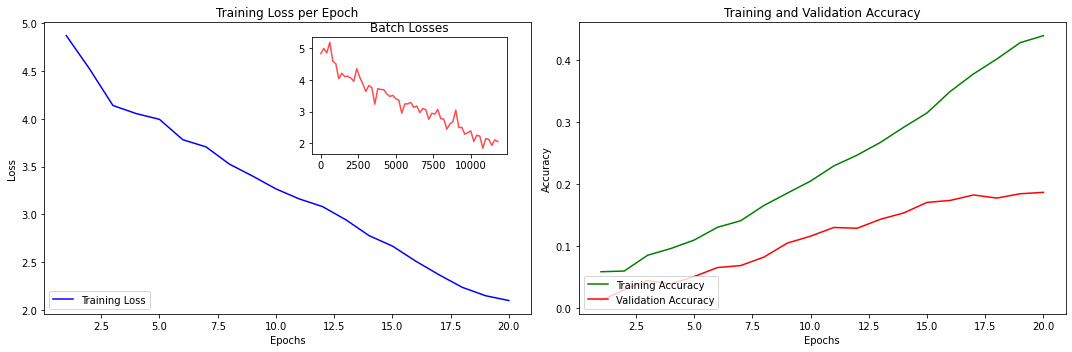

([4.871775792305728,
  4.522203197440948,
  4.1403283024408735,
  4.055341420403446,
  3.9950168247682503,
  3.782076714508026,
  3.706220889187242,
  3.526180899765597,
  3.4006164021281355,
  3.2665329056092536,
  3.161665428115661,
  3.081090905580176,
  2.943228430537335,
  2.7766626209140304,
  2.667915578108715,
  2.5098450947478113,
  2.3672775937371466,
  2.235390224849364,
  2.1475202288014823,
  2.0970301573056296],
 [0.05877915383164645,
  0.0599107311246621,
  0.08530835481234676,
  0.09624693531149808,
  0.10988872823285346,
  0.13050858112780536,
  0.141132834601119,
  0.16583893883196077,
  0.18564154145973472,
  0.2051926824668385,
  0.22971019048217767,
  0.24712390771358522,
  0.2676808952033696,
  0.29213553781354124,
  0.3152700069151946,
  0.35003457597284215,
  0.378386873703401,
  0.4024014584773999,
  0.4286791978374301,
  0.4400578361727541],
 [0.01225,
  0.02975,
  0.0445,
  0.03875,
  0.051,
  0.0655,
  0.06875,
  0.0825,
  0.105,
  0.11625,
  0.13025,
  0.12

In [131]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
995it [00:24, 40.93it/s]


Test Accuracy - Overall: 1.62% | Head: 5.35% | Mid: 0.00% | Tail: 0.00%
Epoch 1/20 completed: val acc=0.016, train acc=0.041, epoch loss=4.865


995it [00:22, 43.84it/s]


Test Accuracy - Overall: 1.95% | Head: 6.41% | Mid: 0.00% | Tail: 0.00%
Epoch 2/20 completed: val acc=0.019, train acc=0.055, epoch loss=4.383


995it [00:23, 43.05it/s]


Test Accuracy - Overall: 3.12% | Head: 9.13% | Mid: 0.87% | Tail: 0.00%
Epoch 3/20 completed: val acc=0.031, train acc=0.062, epoch loss=4.224


995it [00:22, 43.28it/s]


Test Accuracy - Overall: 4.30% | Head: 12.99% | Mid: 0.87% | Tail: 0.00%
Epoch 4/20 completed: val acc=0.043, train acc=0.079, epoch loss=4.002


995it [00:22, 45.20it/s]


Test Accuracy - Overall: 5.20% | Head: 13.98% | Mid: 1.56% | Tail: 1.10%
Epoch 5/20 completed: val acc=0.052, train acc=0.091, epoch loss=3.894


995it [00:22, 43.87it/s]


Test Accuracy - Overall: 5.45% | Head: 14.72% | Mid: 1.93% | Tail: 0.68%
Epoch 6/20 completed: val acc=0.054, train acc=0.106, epoch loss=3.778


995it [00:23, 42.54it/s]


Test Accuracy - Overall: 8.25% | Head: 15.71% | Mid: 7.29% | Tail: 1.87%
Epoch 7/20 completed: val acc=0.083, train acc=0.126, epoch loss=3.660


995it [00:22, 43.51it/s]


Test Accuracy - Overall: 10.47% | Head: 19.16% | Mid: 10.53% | Tail: 1.44%
Epoch 8/20 completed: val acc=0.105, train acc=0.145, epoch loss=3.556


995it [00:23, 42.84it/s]


Test Accuracy - Overall: 11.28% | Head: 21.71% | Mid: 10.34% | Tail: 1.78%
Epoch 9/20 completed: val acc=0.113, train acc=0.169, epoch loss=3.434


995it [00:24, 40.87it/s]


Test Accuracy - Overall: 12.38% | Head: 23.60% | Mid: 11.09% | Tail: 2.54%
Epoch 10/20 completed: val acc=0.124, train acc=0.190, epoch loss=3.303


995it [00:23, 42.36it/s]


Test Accuracy - Overall: 10.70% | Head: 21.55% | Mid: 9.03% | Tail: 1.78%
Epoch 11/20 completed: val acc=0.107, train acc=0.201, epoch loss=3.246


995it [00:23, 42.63it/s]


Test Accuracy - Overall: 15.40% | Head: 25.58% | Mid: 16.45% | Tail: 3.48%
Epoch 12/20 completed: val acc=0.154, train acc=0.222, epoch loss=3.133


995it [00:23, 42.10it/s]


Test Accuracy - Overall: 15.90% | Head: 28.62% | Mid: 14.70% | Tail: 4.41%
Epoch 13/20 completed: val acc=0.159, train acc=0.246, epoch loss=2.993


995it [00:24, 40.14it/s]


Test Accuracy - Overall: 17.10% | Head: 30.59% | Mid: 16.01% | Tail: 4.66%
Epoch 14/20 completed: val acc=0.171, train acc=0.265, epoch loss=2.891


995it [00:24, 40.57it/s]


Test Accuracy - Overall: 18.85% | Head: 31.58% | Mid: 19.25% | Tail: 5.17%
Epoch 15/20 completed: val acc=0.189, train acc=0.295, epoch loss=2.736


995it [00:22, 43.63it/s]


Test Accuracy - Overall: 18.85% | Head: 31.58% | Mid: 18.44% | Tail: 6.28%
Epoch 16/20 completed: val acc=0.189, train acc=0.319, epoch loss=2.613


995it [00:22, 44.26it/s]


Test Accuracy - Overall: 19.12% | Head: 31.00% | Mid: 19.88% | Tail: 5.85%
Epoch 17/20 completed: val acc=0.191, train acc=0.343, epoch loss=2.495


995it [00:21, 46.42it/s]


Test Accuracy - Overall: 19.93% | Head: 33.14% | Mid: 19.44% | Tail: 6.96%
Epoch 18/20 completed: val acc=0.199, train acc=0.361, epoch loss=2.402


995it [00:21, 46.80it/s]


Test Accuracy - Overall: 19.48% | Head: 32.40% | Mid: 19.25% | Tail: 6.45%
Epoch 19/20 completed: val acc=0.195, train acc=0.377, epoch loss=2.348


995it [00:22, 43.85it/s]


Test Accuracy - Overall: 18.68% | Head: 30.26% | Mid: 18.82% | Tail: 6.53%
Epoch 20/20 completed: val acc=0.187, train acc=0.381, epoch loss=2.318


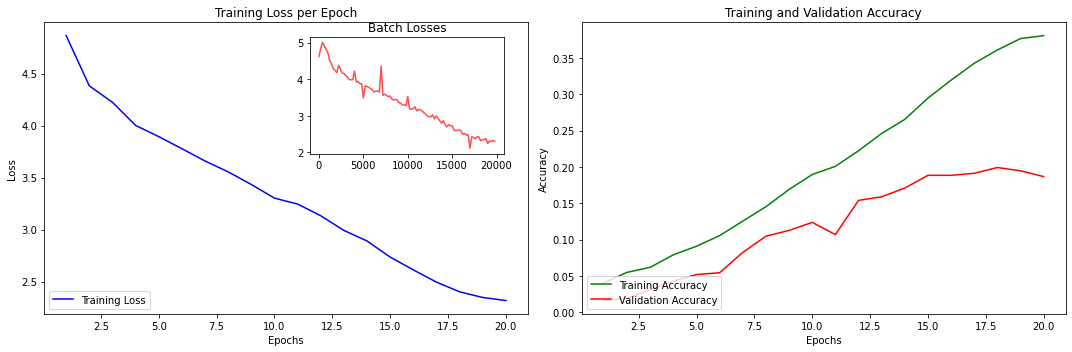

([4.865350962643648,
  4.38254054874631,
  4.22425031398409,
  4.002028106325236,
  3.894320398838676,
  3.778410024978408,
  3.6599797390214164,
  3.55553616974222,
  3.434058252650889,
  3.3031783206978034,
  3.2460531864933033,
  3.1334053389391108,
  2.992587328436387,
  2.8910054441672473,
  2.7359744472120275,
  2.6132559546274154,
  2.495244187925329,
  2.402234129690046,
  2.3475101238519103,
  2.3178736749006874],
 [0.04073678254856353,
  0.055070094926761806,
  0.0619852894951908,
  0.07921041051109574,
  0.09093480857484126,
  0.10561388068146099,
  0.12551078141698624,
  0.14534481674734392,
  0.16904507449550513,
  0.18963349468787327,
  0.2008235368076947,
  0.22226063996982462,
  0.24602376312315333,
  0.2654177406173383,
  0.29471301942541017,
  0.31935625825108443,
  0.3425850254604891,
  0.3608474256616584,
  0.3765637769535425,
  0.3806185955868486],
 [0.01625,
  0.0195,
  0.03125,
  0.043,
  0.052,
  0.0545,
  0.0825,
  0.10475,
  0.11275,
  0.12375,
  0.107,
  0.15

In [132]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(augmentedLT), torch.Tensor(augmentedLabelsLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)

/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javvaji.m/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
1140it [00:25, 44.75it/s]


Test Accuracy - Overall: 4.40% | Head: 3.29% | Mid: 2.06% | Tail: 8.74%
Epoch 1/20 completed: val acc=0.044, train acc=0.041, epoch loss=4.844


1140it [00:23, 47.86it/s]


Test Accuracy - Overall: 6.00% | Head: 7.89% | Mid: 2.93% | Tail: 8.23%
Epoch 2/20 completed: val acc=0.060, train acc=0.107, epoch loss=4.039


1140it [00:25, 44.30it/s]


Test Accuracy - Overall: 9.18% | Head: 12.83% | Mid: 6.42% | Tail: 9.16%
Epoch 3/20 completed: val acc=0.092, train acc=0.161, epoch loss=3.631


1140it [00:25, 45.43it/s]


Test Accuracy - Overall: 9.75% | Head: 12.50% | Mid: 7.29% | Tail: 10.26%
Epoch 4/20 completed: val acc=0.098, train acc=0.221, epoch loss=3.238


1140it [00:27, 41.46it/s]


Test Accuracy - Overall: 11.30% | Head: 14.72% | Mid: 9.78% | Tail: 9.84%
Epoch 5/20 completed: val acc=0.113, train acc=0.243, epoch loss=3.115


1140it [00:25, 44.48it/s]


Test Accuracy - Overall: 12.57% | Head: 17.52% | Mid: 10.65% | Tail: 10.09%
Epoch 6/20 completed: val acc=0.126, train acc=0.305, epoch loss=2.794


1140it [00:23, 47.51it/s]


Test Accuracy - Overall: 16.23% | Head: 22.29% | Mid: 15.76% | Tail: 10.60%
Epoch 7/20 completed: val acc=0.162, train acc=0.382, epoch loss=2.417


1140it [00:25, 44.46it/s]


Test Accuracy - Overall: 17.05% | Head: 21.13% | Mid: 16.51% | Tail: 13.57%
Epoch 8/20 completed: val acc=0.171, train acc=0.411, epoch loss=2.297


1140it [00:26, 42.55it/s]


Test Accuracy - Overall: 17.45% | Head: 26.56% | Mid: 15.95% | Tail: 10.09%
Epoch 9/20 completed: val acc=0.174, train acc=0.441, epoch loss=2.159


1140it [00:27, 41.48it/s]


Test Accuracy - Overall: 19.35% | Head: 26.81% | Mid: 19.88% | Tail: 10.94%
Epoch 10/20 completed: val acc=0.194, train acc=0.509, epoch loss=1.840


1140it [00:25, 44.36it/s]


Test Accuracy - Overall: 20.18% | Head: 30.76% | Mid: 19.25% | Tail: 10.52%
Epoch 11/20 completed: val acc=0.202, train acc=0.569, epoch loss=1.590


1140it [00:25, 44.29it/s]


Test Accuracy - Overall: 20.75% | Head: 30.43% | Mid: 20.62% | Tail: 10.94%
Epoch 12/20 completed: val acc=0.207, train acc=0.625, epoch loss=1.353


1140it [00:25, 43.94it/s]


Test Accuracy - Overall: 21.25% | Head: 31.58% | Mid: 20.87% | Tail: 11.11%
Epoch 13/20 completed: val acc=0.212, train acc=0.648, epoch loss=1.276


1140it [00:25, 43.86it/s]


Test Accuracy - Overall: 21.73% | Head: 32.89% | Mid: 20.93% | Tail: 11.28%
Epoch 14/20 completed: val acc=0.217, train acc=0.702, epoch loss=1.057


1140it [00:28, 40.49it/s]


Test Accuracy - Overall: 21.40% | Head: 31.33% | Mid: 21.25% | Tail: 11.37%
Epoch 15/20 completed: val acc=0.214, train acc=0.759, epoch loss=0.856


1140it [00:26, 43.24it/s]


Test Accuracy - Overall: 21.60% | Head: 33.55% | Mid: 21.06% | Tail: 10.01%
Epoch 16/20 completed: val acc=0.216, train acc=0.798, epoch loss=0.718


1140it [00:26, 43.81it/s]


Test Accuracy - Overall: 21.80% | Head: 33.06% | Mid: 21.06% | Tail: 11.20%
Epoch 17/20 completed: val acc=0.218, train acc=0.824, epoch loss=0.634


1140it [00:25, 44.05it/s]


Test Accuracy - Overall: 21.80% | Head: 33.22% | Mid: 21.37% | Tail: 10.60%
Epoch 18/20 completed: val acc=0.218, train acc=0.854, epoch loss=0.546


1140it [00:27, 41.69it/s]


Test Accuracy - Overall: 21.82% | Head: 33.47% | Mid: 21.37% | Tail: 10.43%
Epoch 19/20 completed: val acc=0.218, train acc=0.868, epoch loss=0.501


1140it [00:27, 42.00it/s]


Test Accuracy - Overall: 21.68% | Head: 32.89% | Mid: 21.31% | Tail: 10.60%
Epoch 20/20 completed: val acc=0.217, train acc=0.873, epoch loss=0.477


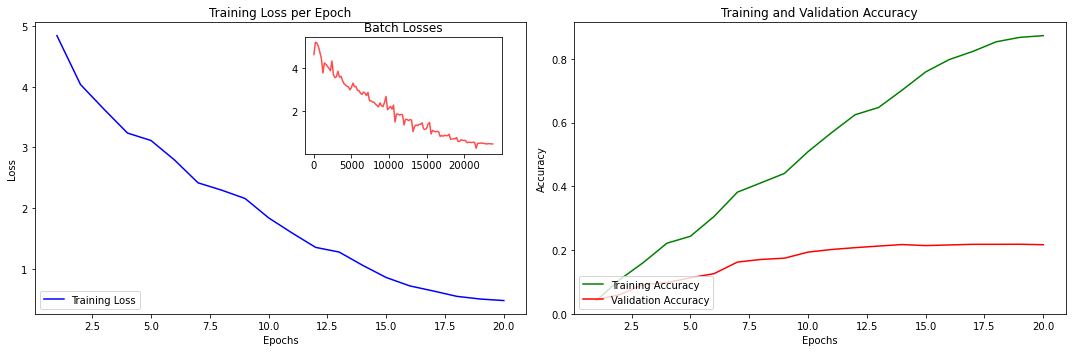

([4.843533778608891,
  4.039196028207478,
  3.631258973949834,
  3.2378416797571017,
  3.115047386445497,
  2.793547598207206,
  2.417372861975118,
  2.29687204350505,
  2.158864157137118,
  1.8399513505529939,
  1.589889347605538,
  1.3530399485115419,
  1.2758254551573804,
  1.0569061118782612,
  0.8563288765256865,
  0.7183015256858709,
  0.6344119028825509,
  0.5459004425819506,
  0.5014872436852832,
  0.47657089083079707],
 [0.04140048803224303,
  0.10739451100814301,
  0.16091355249088365,
  0.2214514846598854,
  0.24333068297096483,
  0.30510240451841086,
  0.3818989389411345,
  0.41112603843939355,
  0.4407095659803142,
  0.5089244098374139,
  0.5685849806706331,
  0.6248731938694376,
  0.6477394236832725,
  0.7021906615852823,
  0.7593836536616126,
  0.7981246401447646,
  0.823568118882461,
  0.8539741726756779,
  0.867874866339484,
  0.873303539604639],
 [0.044,
  0.06,
  0.09175,
  0.0975,
  0.113,
  0.12575,
  0.16225,
  0.1705,
  0.1745,
  0.1935,
  0.20175,
  0.2075,
  0.

In [133]:
# Model
backbone = DINOBackbone()
backbone.load_state_dict(torch.load("dinoBackbone1.pth"))
modelDino = DinoClassifier(backbone)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(generatedLT), torch.Tensor(generatedLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(modelDino.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
modelDino.to(device)
train_model(trainLoader, valLoader, 20, modelDino, optimizer, scheduler, loss)